In [1]:
import numpy as np
from tqdm import tqdm
import sys
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from mpl_toolkits.mplot3d import Axes3D

sys.path.append("..")  # Avoid error with importing of src
from src.utils_py.profile_approx import _profile_approx_from_array, L1, grad_L1
from src.utils_py.interface import *

In [2]:
# Load Helvetica font from file
root = os.environ['HOME']
font_path = f"{root}/HelveticaNeue.ttc"  # Update this path
helvetica_font = fm.FontProperties(fname=font_path)

---

## Testing dens profile

In [3]:
z, dens = np.loadtxt("../data/profile_scale_0.7_time_38_ns.txt", skiprows=1, comments=["@", "#"], unpack=True)

In [4]:
H = 9
l, phi = 18.004 / H, 0.5
rho_bulk = 3.0896 * 10
interface_type = 'roll'

# Define storage for tracking values
history = []

# Callback function to store the optimization history
def callback(xk):
    history.append(xk)

_, _, best = _profile_approx_from_array(
    dens * rho_bulk, z * H, rho_bulk, l, phi, H, interface_type, samples=1, display=True, method="L-BFGS-B", callback=callback
)

history = np.array(history)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.86725D+01    |proj g|=  4.13259D-01

At iterate    1    f=  9.03682D+00    |proj g|=  1.19866D+00

At iterate    2    f=  2.93071D+00    |proj g|=  1.04792D+00

At iterate    3    f=  2.89347D+00    |proj g|=  1.04149D+00

At iterate    4    f=  2.86966D+00    |proj g|=  1.02979D+00

At iterate    5    f=  2.85326D+00    |proj g|=  1.02369D+00

At iterate    6    f=  2.77629D+00    |proj g|=  5.68304D-02

At iterate    7    f=  2.77144D+00    |proj g|=  1.71414D-01

At iterate    8    f=  2.73956D+00    |proj g|=  2.69354D-01

At iterate    9    f=  2.71688D+00    |proj g|=  8.88720D-01

At iterate   10    f=  2.71155D+00    |proj g|=  7.65049D-01

At iterate   11    f=  2.71078D+00    |proj g|=  6.43741D-01

At iterate   12    f=  2.70841D+00    |proj g|=  4.62043D-01

At iterate   13    f=  2.7


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [5]:
history

array([[1.94293573, 0.        ],
       [2.09367702, 0.03155135],
       [2.10010283, 0.03254719],
       [2.1117987 , 0.03340752],
       [2.11790111, 0.03309887],
       [2.16551012, 0.03148783],
       [2.16855507, 0.03131746],
       [2.17814287, 0.02991225],
       [2.19196763, 0.02845649],
       [2.19985376, 0.02799854],
       [2.20136215, 0.02792848],
       [2.20656765, 0.02795665],
       [2.21614192, 0.0278748 ]])

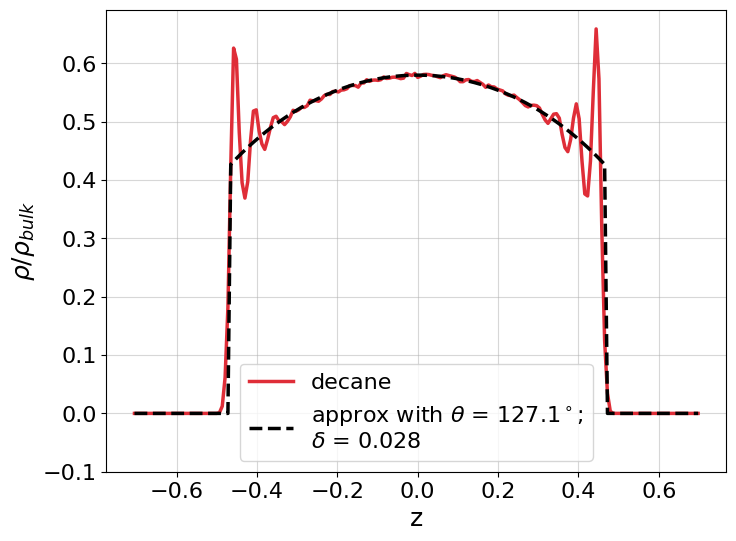

In [12]:
H = 9
l, phi = 18.004 / H, 0.5
rho_bulk = 3.0896 * 10

plt.figure(figsize=(8, 6))

plt.grid(alpha=0.5)
plt.plot(
    z, dens,
    label='decane',
    color='#DF2E38',
    linewidth=2.5
)

plt.plot(
    z, rho_roll_alpha(z, l, phi, best['theta'], best['delta']),
    label=r'approx with $\theta$ = {:.1f}$^\circ$;'.format(np.rad2deg(best["theta"]))+'\n'+'$\delta$ = {:.3f}'.format(best["delta"]),
    color='#000000',
    linewidth=2.5,
    linestyle='dashed'
)

plt.xlabel('z', fontsize=18)
plt.ylabel(r'$\rho / \rho_{bulk}$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='lower center', fontsize=16)
plt.ylim(bottom=-0.1)
# plt.savefig('img/density_profile_calcite_decane.png')
plt.show()

---

## Drawing 3d surface with gradients

In [76]:
def project_gradient_on_tangent_plane(fx, fy):
    """
    Projects the gradient vectors G = (fx, fy, 0) onto the tangent plane defined by
    tangent vectors v_x and v_y for a grid of points.

    Parameters:
        fx: np.ndarray - 2D array of partial derivatives of f with respect to x.
        fy: np.ndarray - 2D array of partial derivatives of f with respect to y.

    Returns:
        tuple of np.ndarray: Three 2D arrays (u, v, w) representing the components of
        the projected gradient vectors in the 3D space.
    """
    # Ensure fx and fy are 2D arrays
    assert fx.shape == fy.shape, "fx and fy must have the same shape"

    # Get the shape of the input grid
    shape = fx.shape

    # Initialize arrays for the projected gradient components
    u = np.zeros(shape)
    v = np.zeros(shape)
    w = np.zeros(shape)

    # Iterate over each grid point to compute the projection
    for i in range(shape[0]):
        for j in range(shape[1]):
            # Tangent vectors at each grid point
            # v_x = np.array([1, 0, fx[i, j]])  # Tangent vector along x
            # v_y = np.array([0, 1, fy[i, j]])  # Tangent vector along y
            v_x = -np.sign(fx[i, j]) * np.array([1, 0, fx[i, j]])
            v_y = -np.sign(fy[i, j]) * np.array([0, 1, fy[i, j]])


            # Gradient vector at the grid point
            G = -np.array([fx[i, j], fy[i, j], 0])

            # Compute the Gram matrix (Gij = vi \cdot vj)
            G_matrix = np.array([
                [np.dot(v_x, v_x), np.dot(v_x, v_y)],
                [np.dot(v_y, v_x), np.dot(v_y, v_y)]
            ])

            # Compute the right-hand side vector (dot products of G with v_x and v_y)
            rhs = np.array([
                np.dot(G, v_x),
                np.dot(G, v_y)
            ])

            # Solve for the coefficients a and b
            coeffs = np.linalg.solve(G_matrix, rhs)
            a, b = coeffs
            # detom = 1 + fx[i, j]**2 + fy[i, j]**2

            # a = - fx[i, j] * (1 + 2 * fy[i, j]**2) / detom
            # b = - fy[i, j] * (1 + 2 * fx[i, j]**2) / detom

            # Compute the projection of G onto the tangent plane
            G_proj = a * v_x + b * v_y

            # Store the components of the projected gradient
            u[i, j], v[i, j], w[i, j] = G_proj

    return u, v, w

In [96]:
# Define the grid for plotting
N = 30
theta_vals = np.linspace(np.pi/2+np.deg2rad(1), np.pi, N)
delta_vals = np.linspace(0, 0.08, N)
Theta, Delta = np.meshgrid(theta_vals, delta_vals)

# Compute L1 values on the grid
L1_values = np.zeros_like(Theta)
for i in range(Theta.shape[0]):
    for j in range(Theta.shape[1]):
        L1_values[i, j] = L1(
            [Theta[i, j], Delta[i, j]], z, dens, l, phi, rho_roll_alpha
        )

# Compute gradients for each grid point
Grad_Theta = np.zeros_like(Theta)
Grad_Delta = np.zeros_like(Delta)
for i in range(Theta.shape[0]):
    for j in range(Theta.shape[1]):
        grad = grad_L1(
            [Theta[i, j], Delta[i, j]], z, dens, l, phi, rho_roll_alpha, grad_rho_roll_alpha
        )
        Grad_Theta[i, j] = grad[0]
        Grad_Delta[i, j] = grad[1]

u, v, w = project_gradient_on_tangent_plane(Grad_Theta, Grad_Delta)

In [97]:
# Directory for saving frames
folder = "../data/3d_frames"
if not os.path.exists(folder):
    os.makedirs(folder)

In [ ]:
for i, phi in enumerate(np.linspace(0, 360, 100)[:-1]):
    # Plot the 3D surface of L1 function
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(np.rad2deg(Theta), Delta, L1_values, cmap="viridis", alpha=0.8)
    # fig.colorbar(surf, label="L1 Function Value")

    # Add quiver plot for tangential gradients
    # quiver_scale = 0.51  # Scale for arrows in 3D
    # ax.quiver(
    #     Theta, Delta, L1_values,  # Base of the arrows starts at the surface
    #     u, v, w,  # Tangential gradient vectors
    #     color='black', length=quiver_scale, normalize=True, arrow_length_ratio=0, linewidths=1
    # )

    ax.set_title("3D Surface of L1 Function with Tangential Gradient Vectors", fontsize=16)
    ax.set_xlabel("Theta", fontsize=14)
    ax.set_ylabel("Delta", fontsize=14)
    ax.set_zlabel("L1 Function Value", fontsize=14)
    # Set the view angle to rotate around Z-axis
    ax.view_init(elev=30, azim=phi-20)  # Elevation = 30 degrees, Azimuth = 45 degrees

    plt.tight_layout()
    plt.savefig(os.path.join(folder, f"frame_{i:03d}.png"))
    # plt.show()
    plt.close(fig)

---

## Drawing animation

1


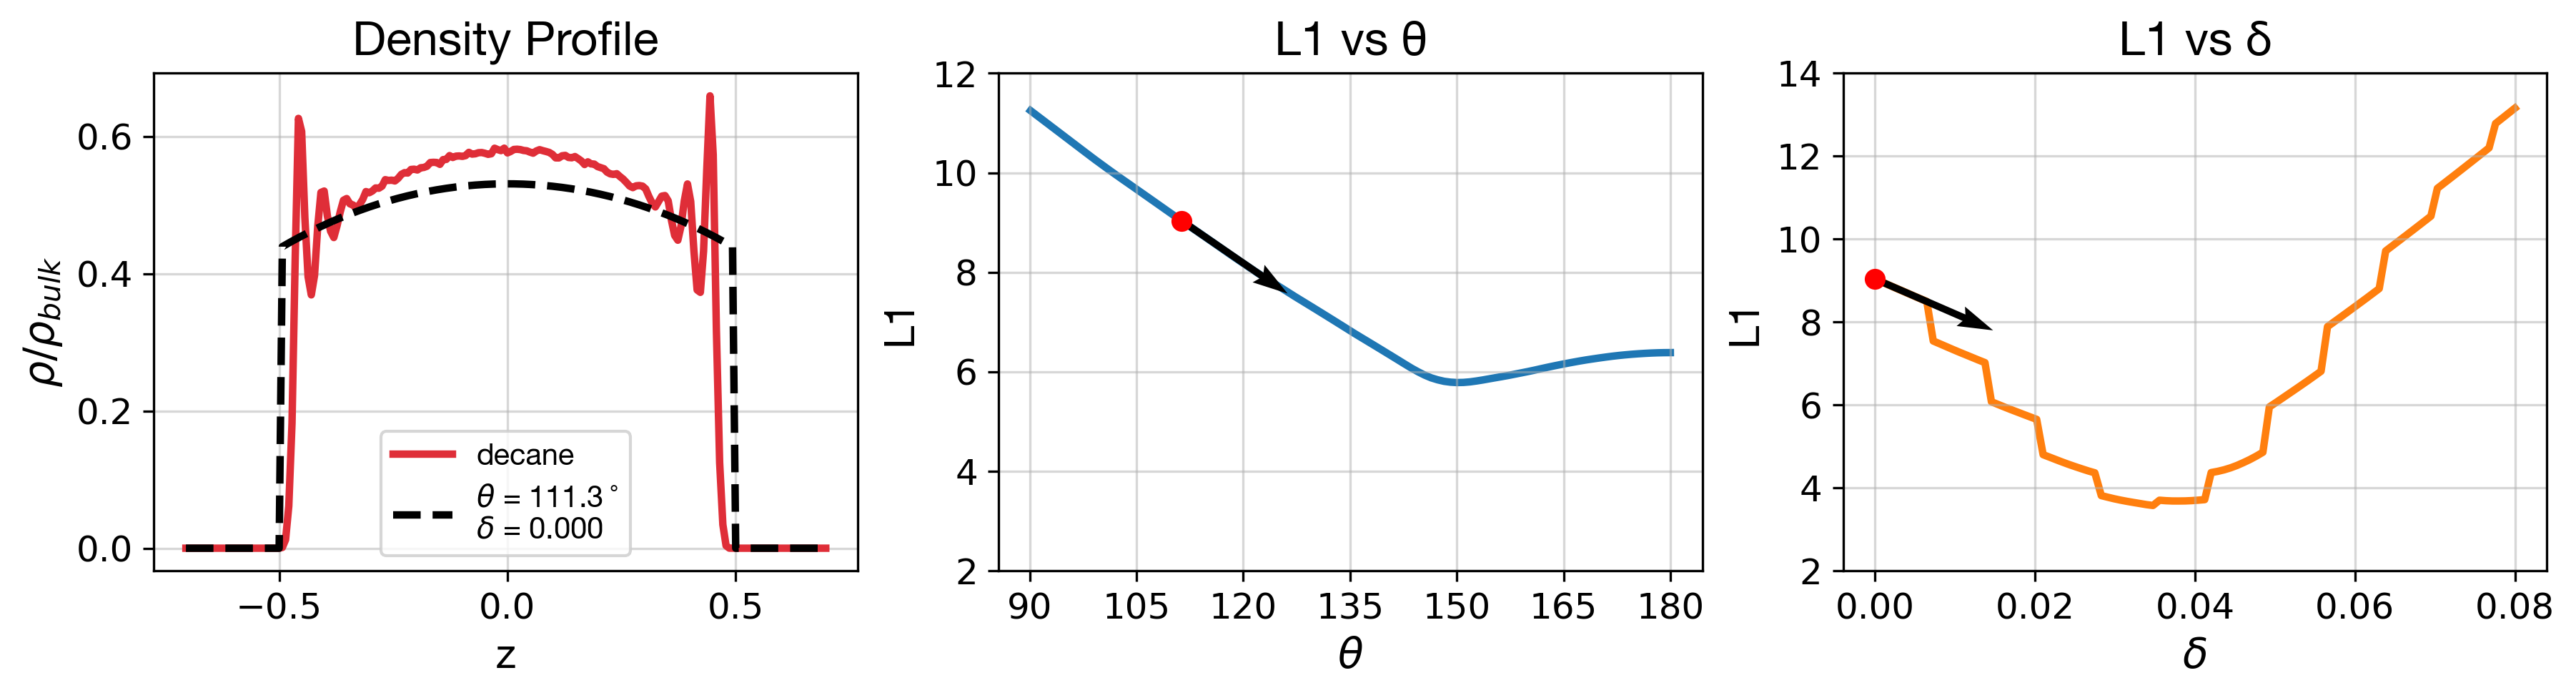

2


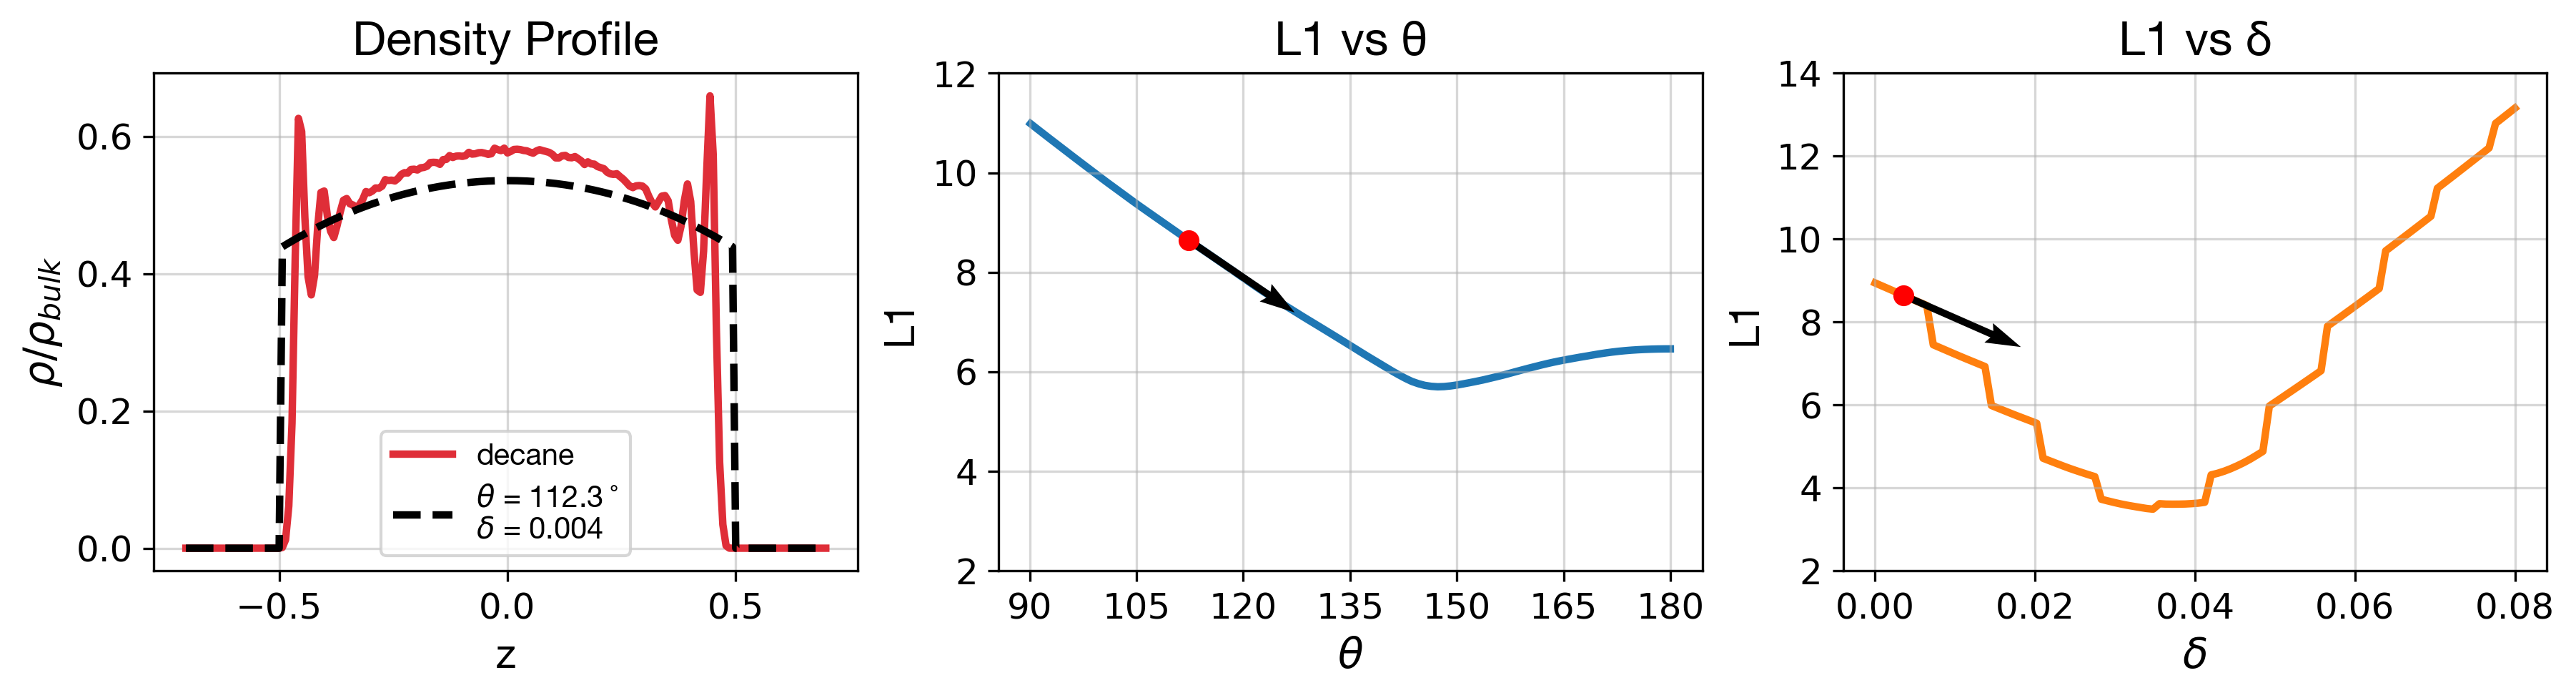

3


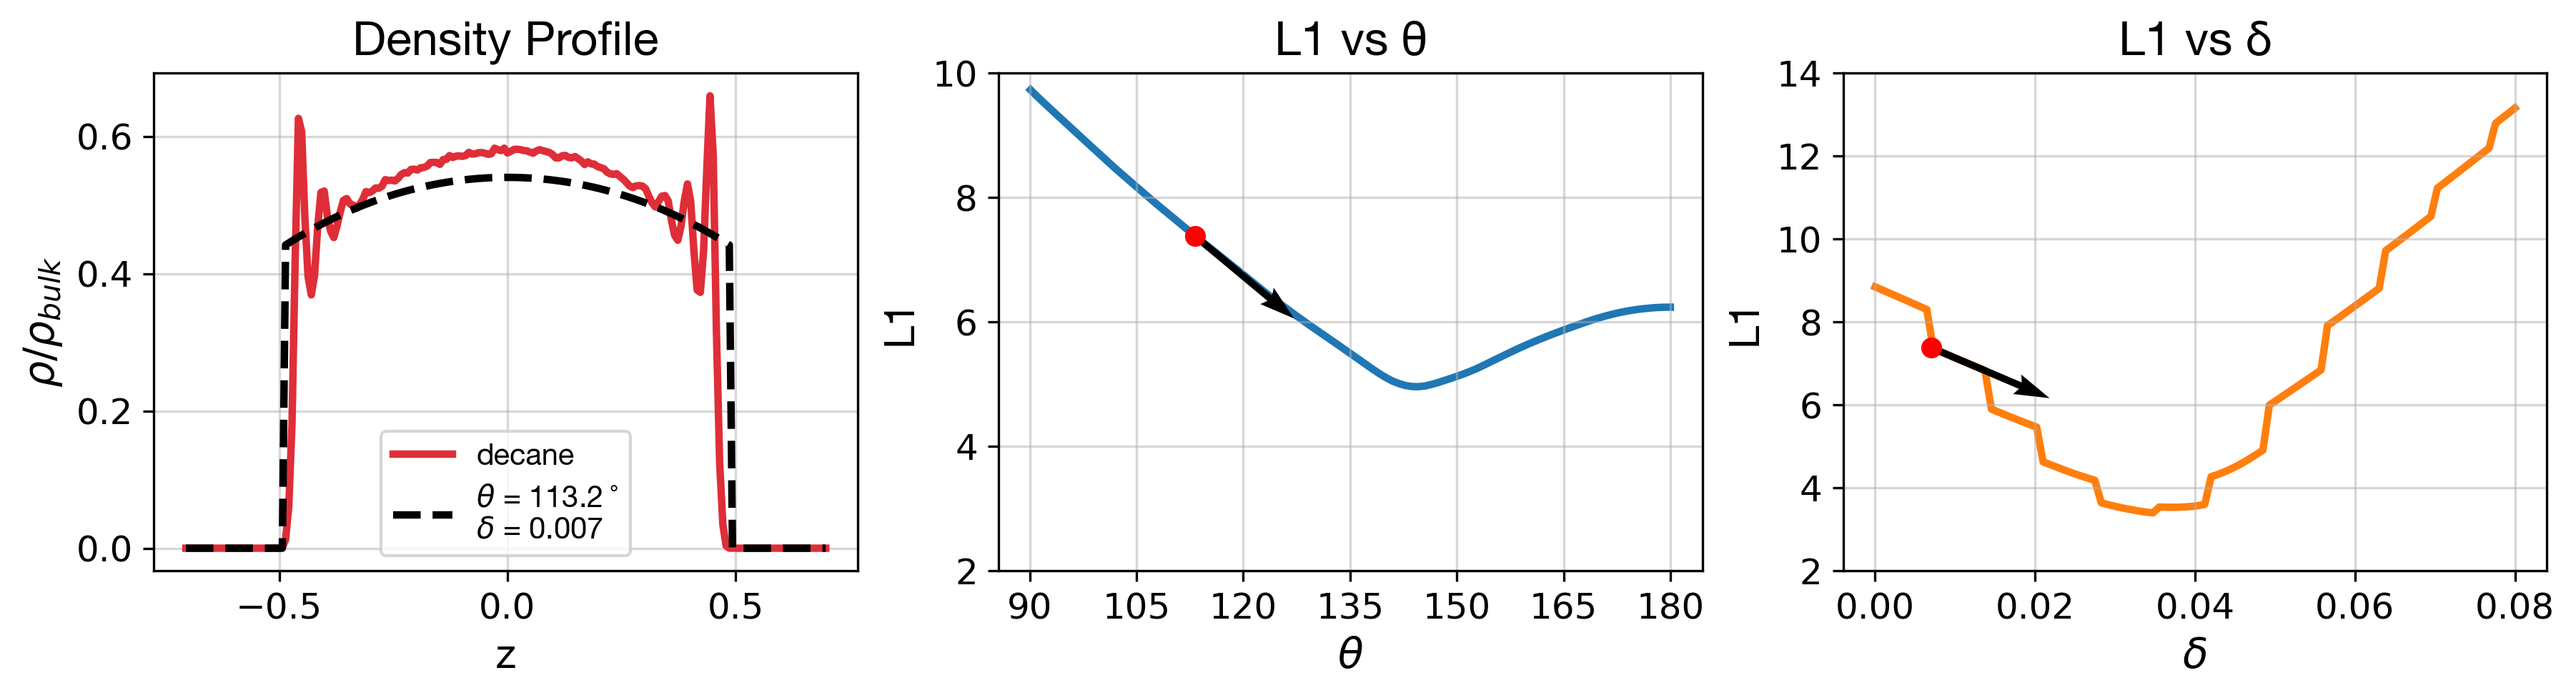

4


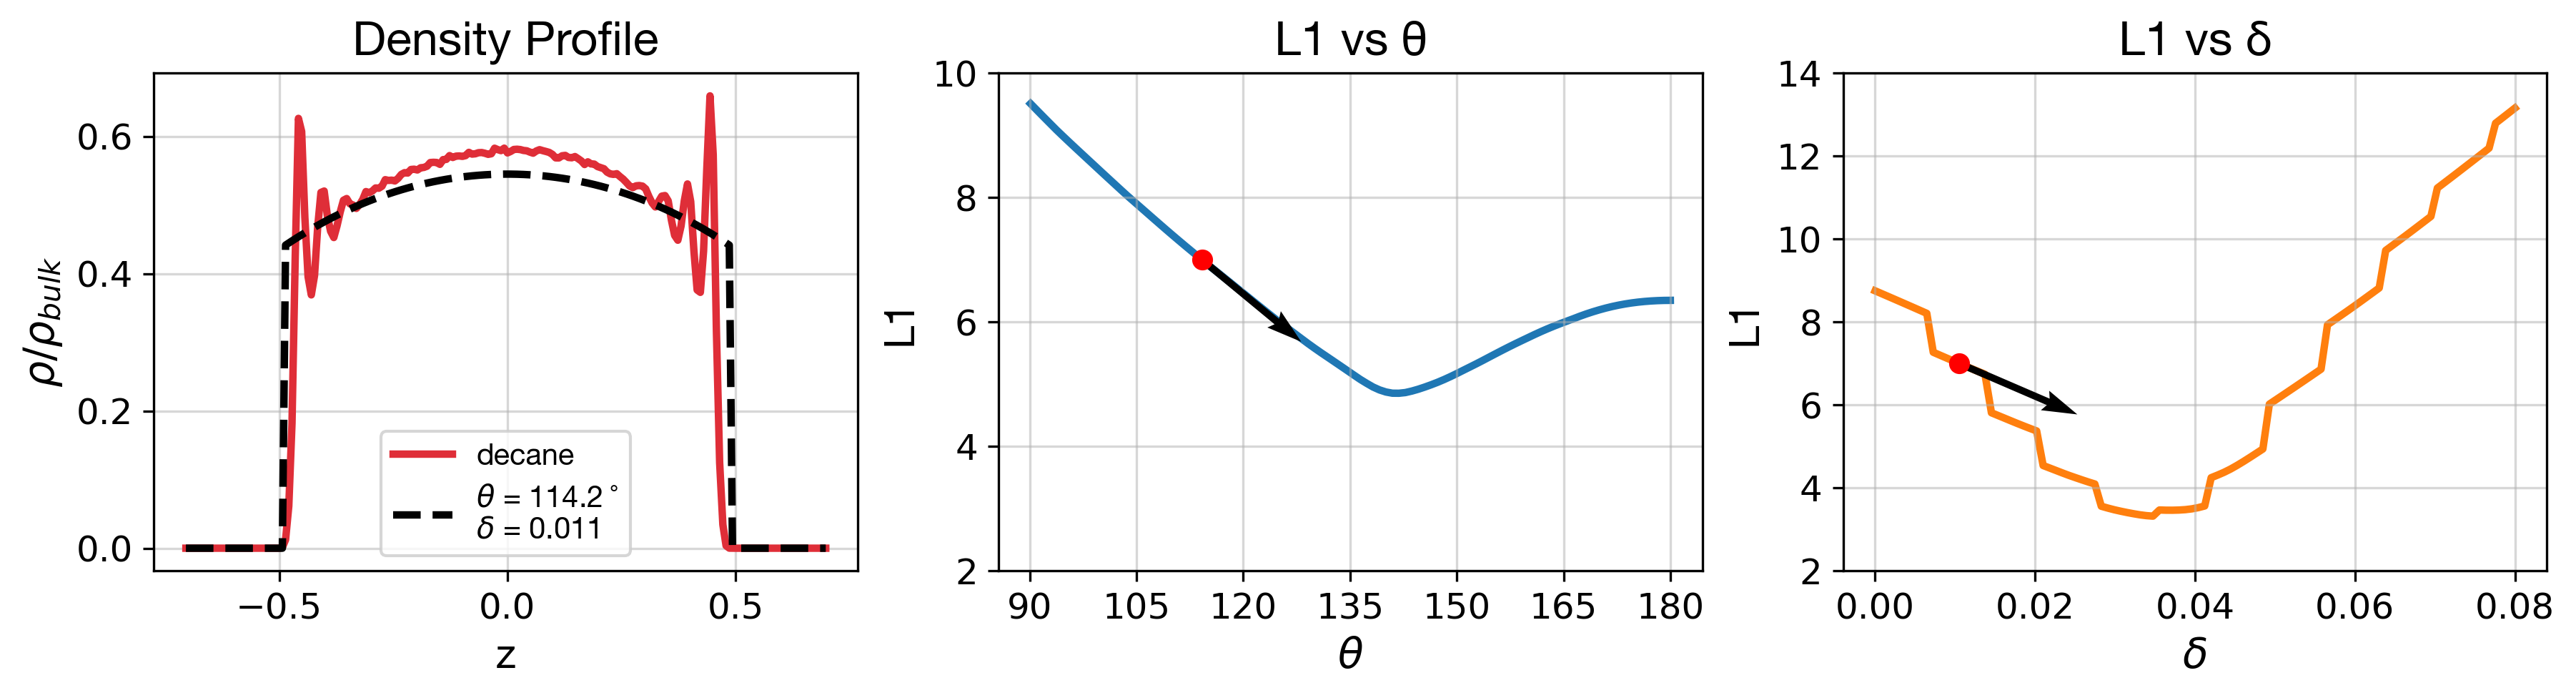

5


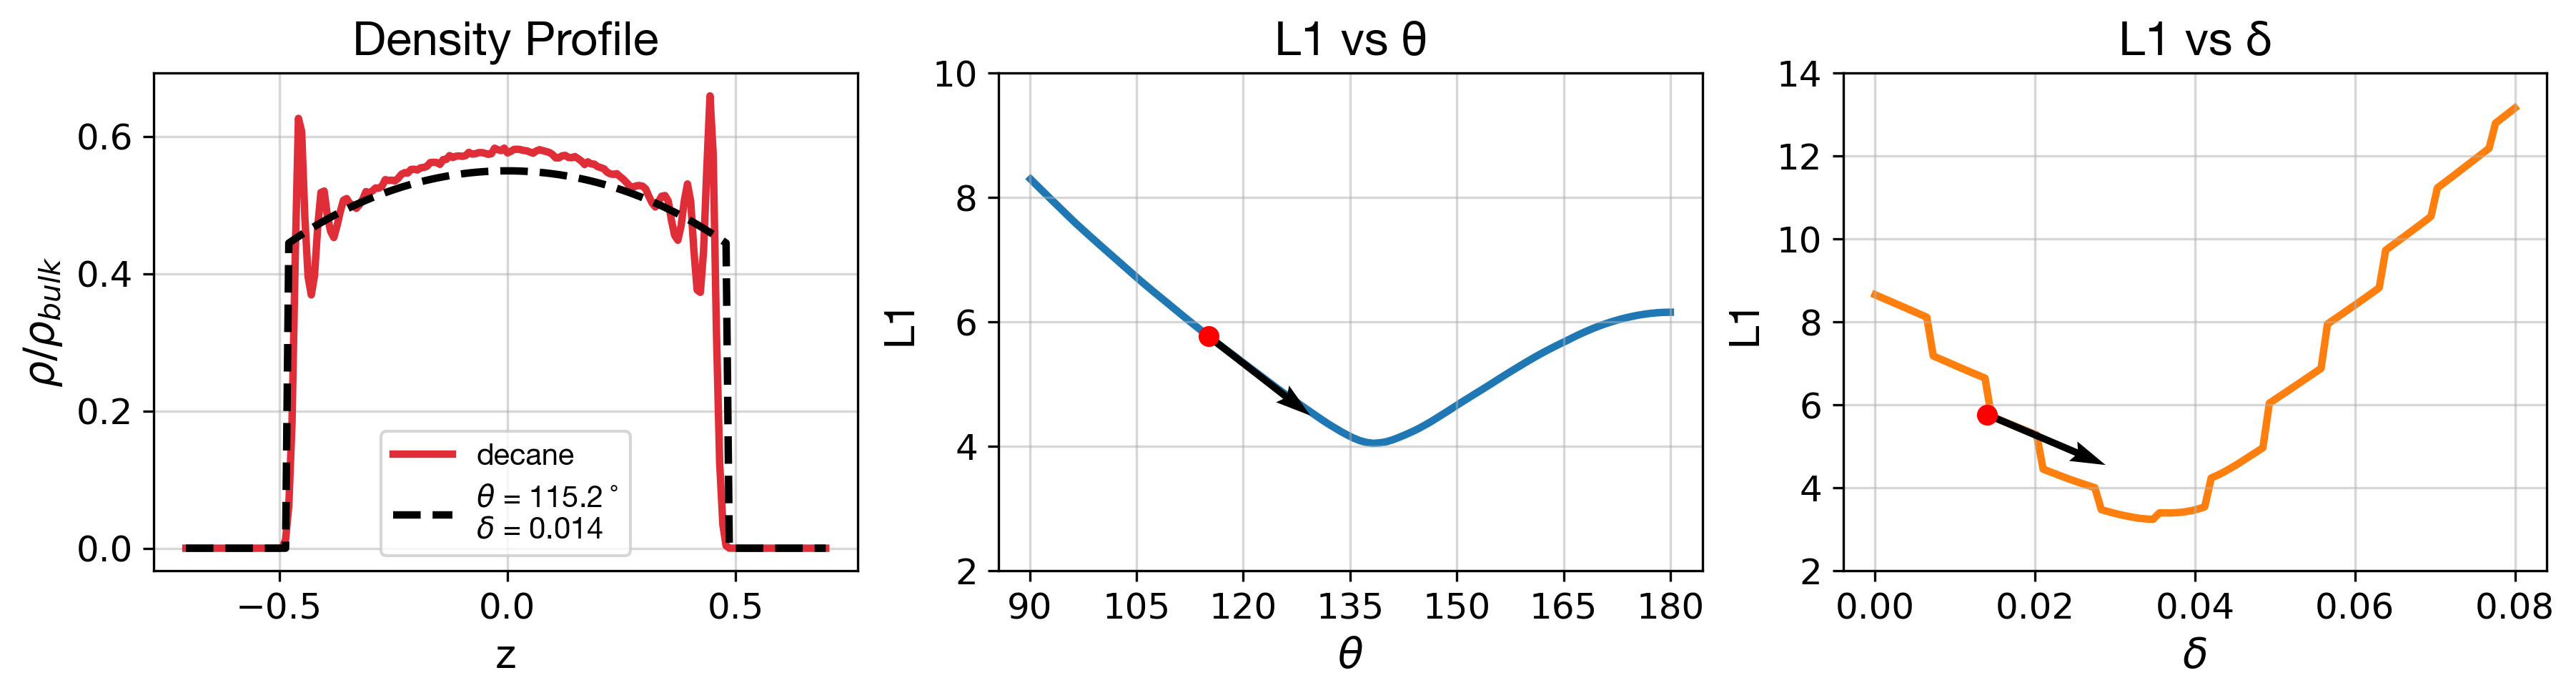

6


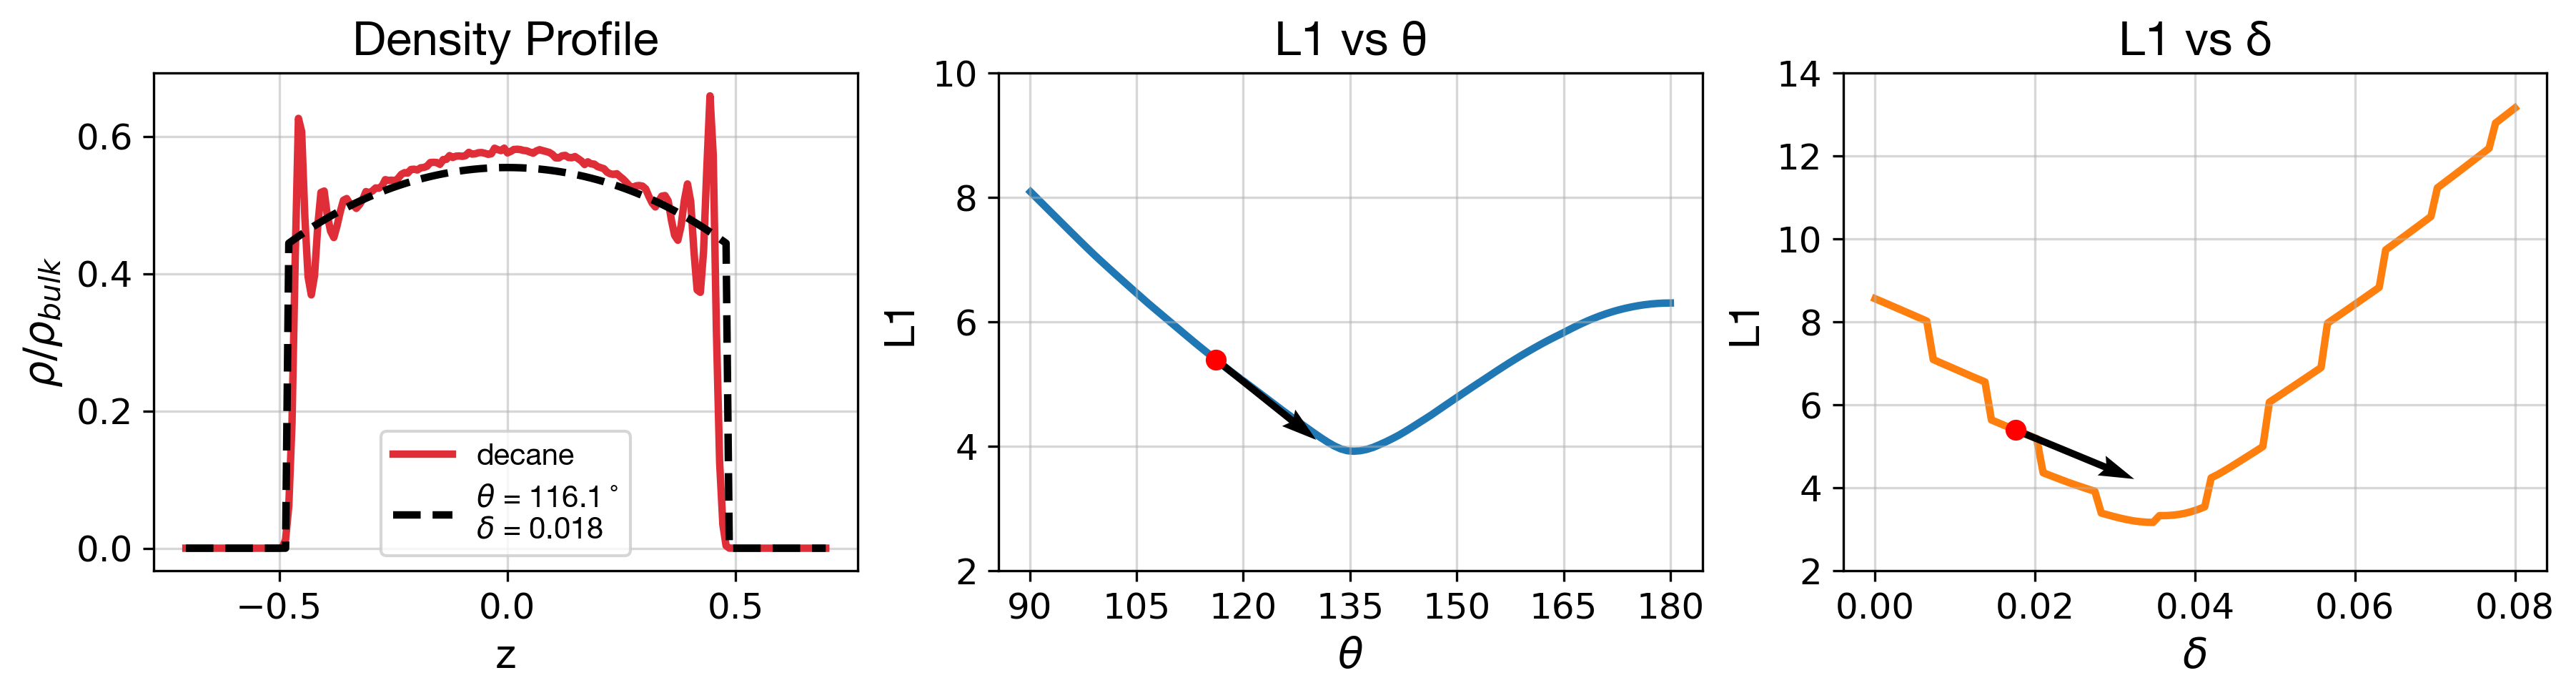

7


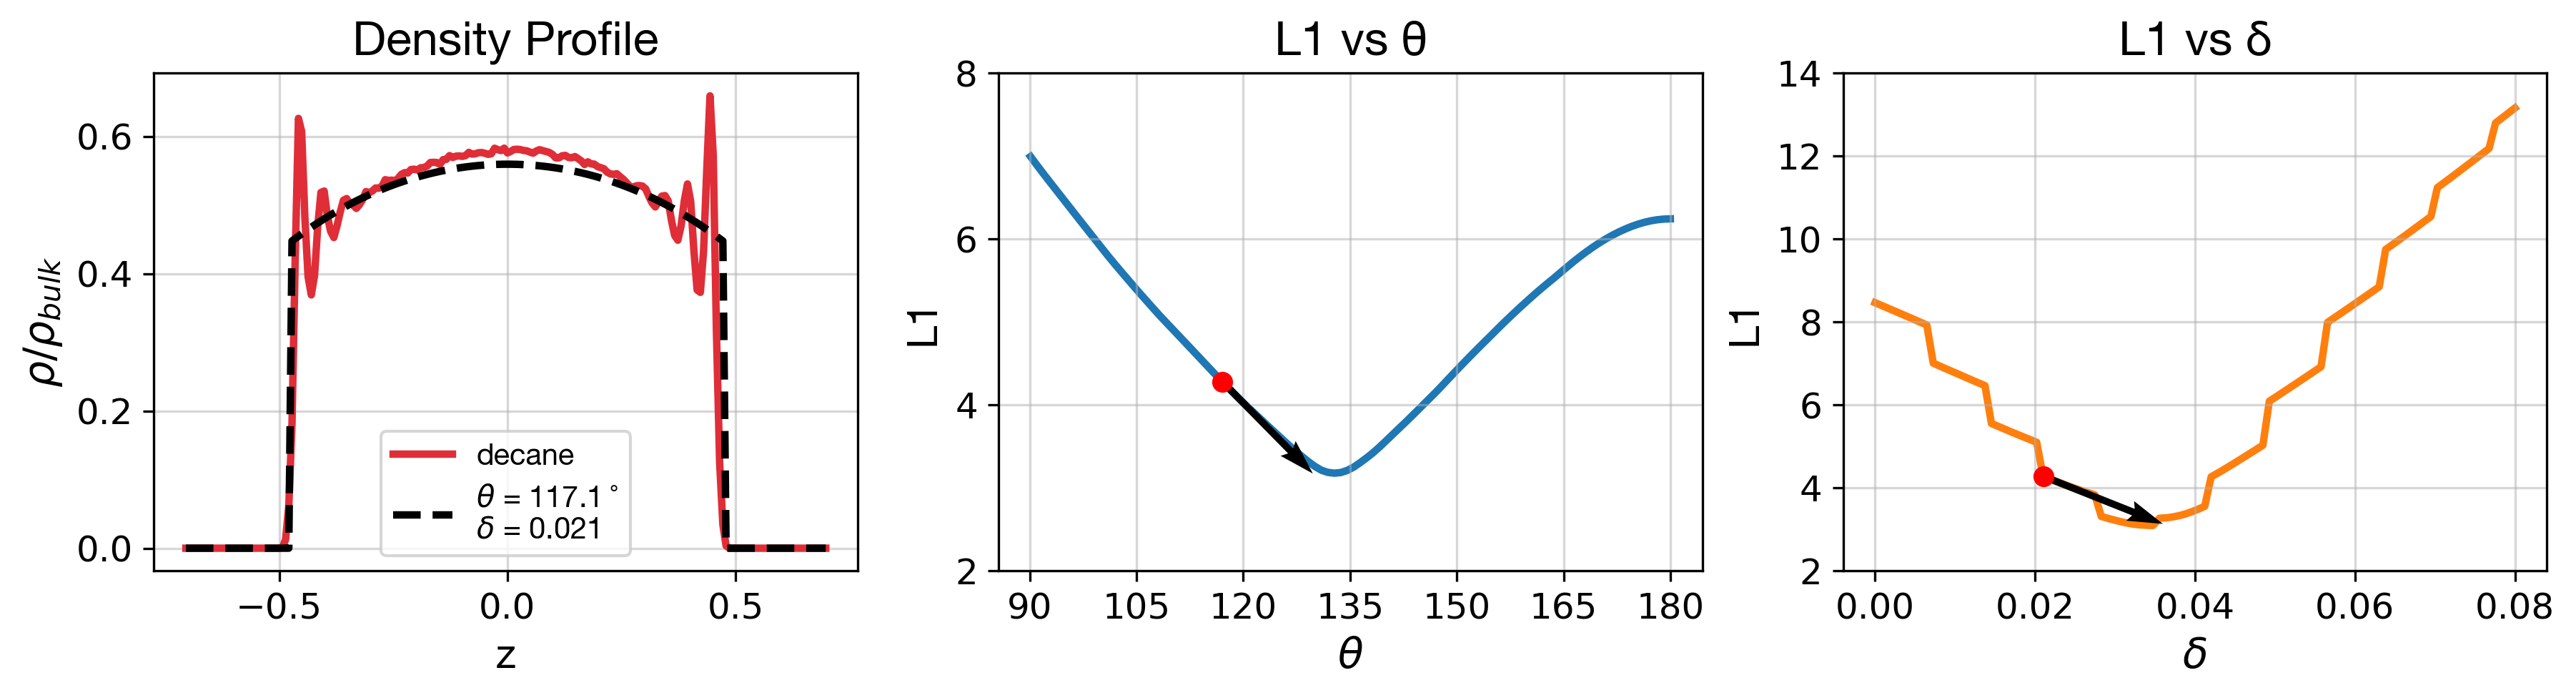

8


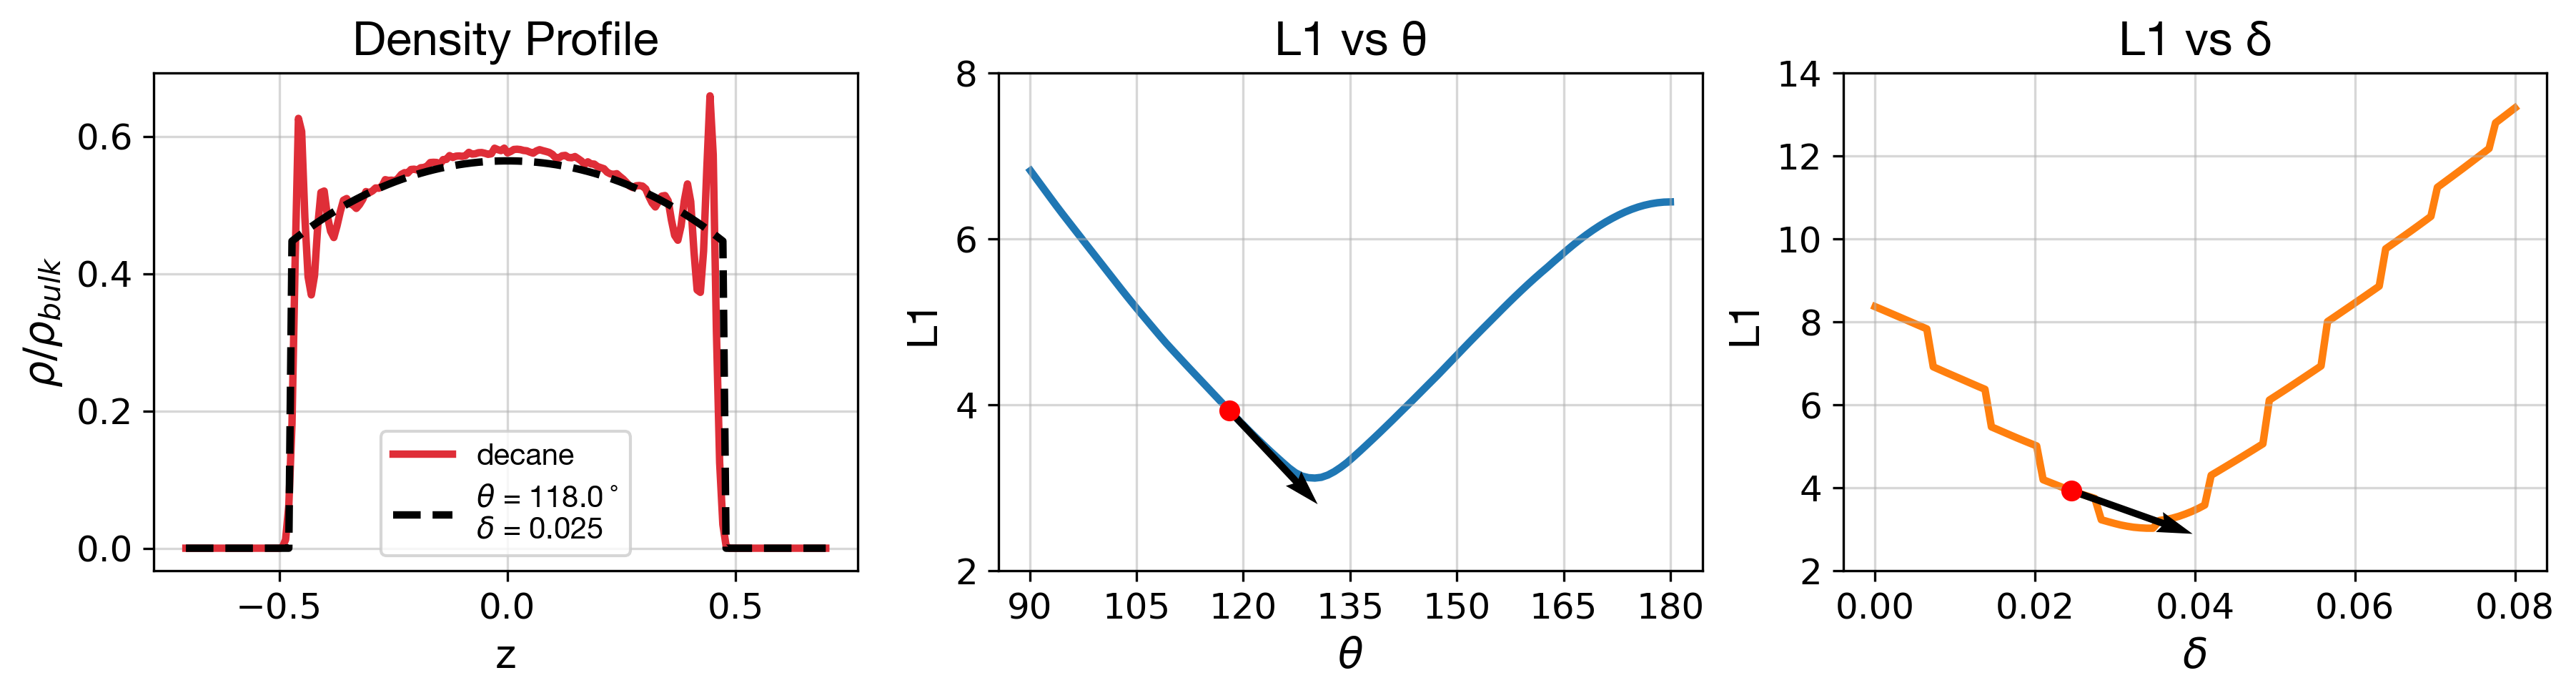

9


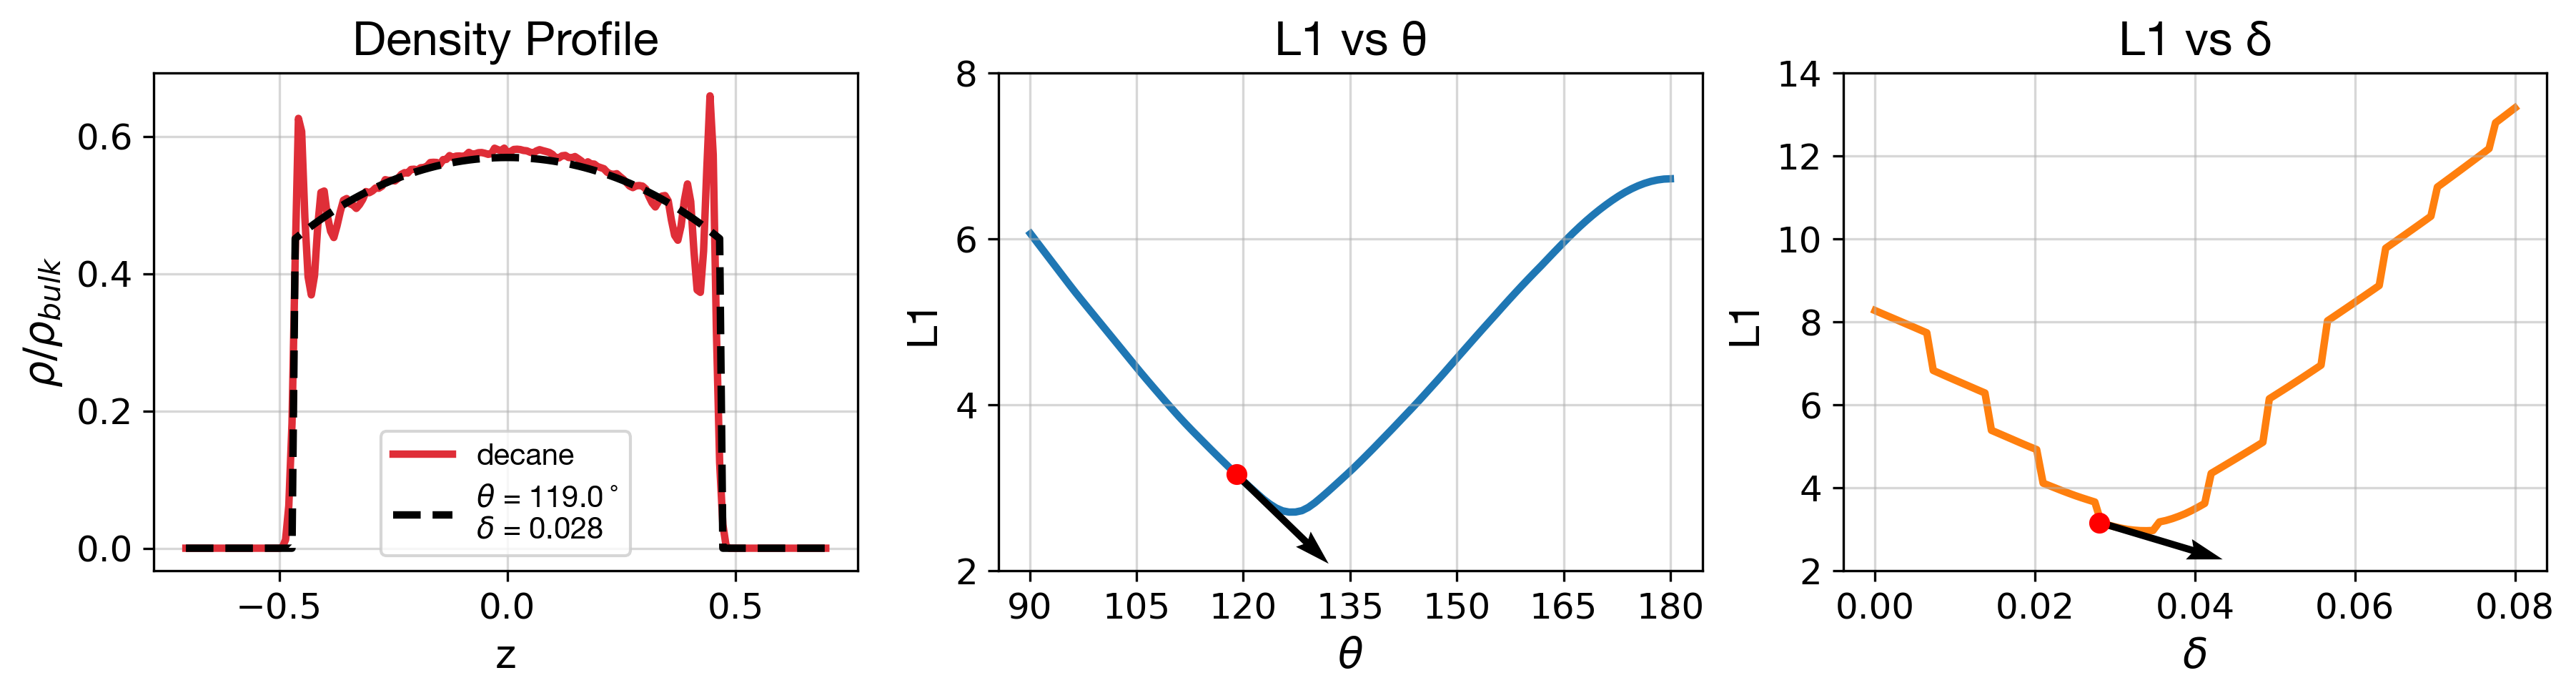

10


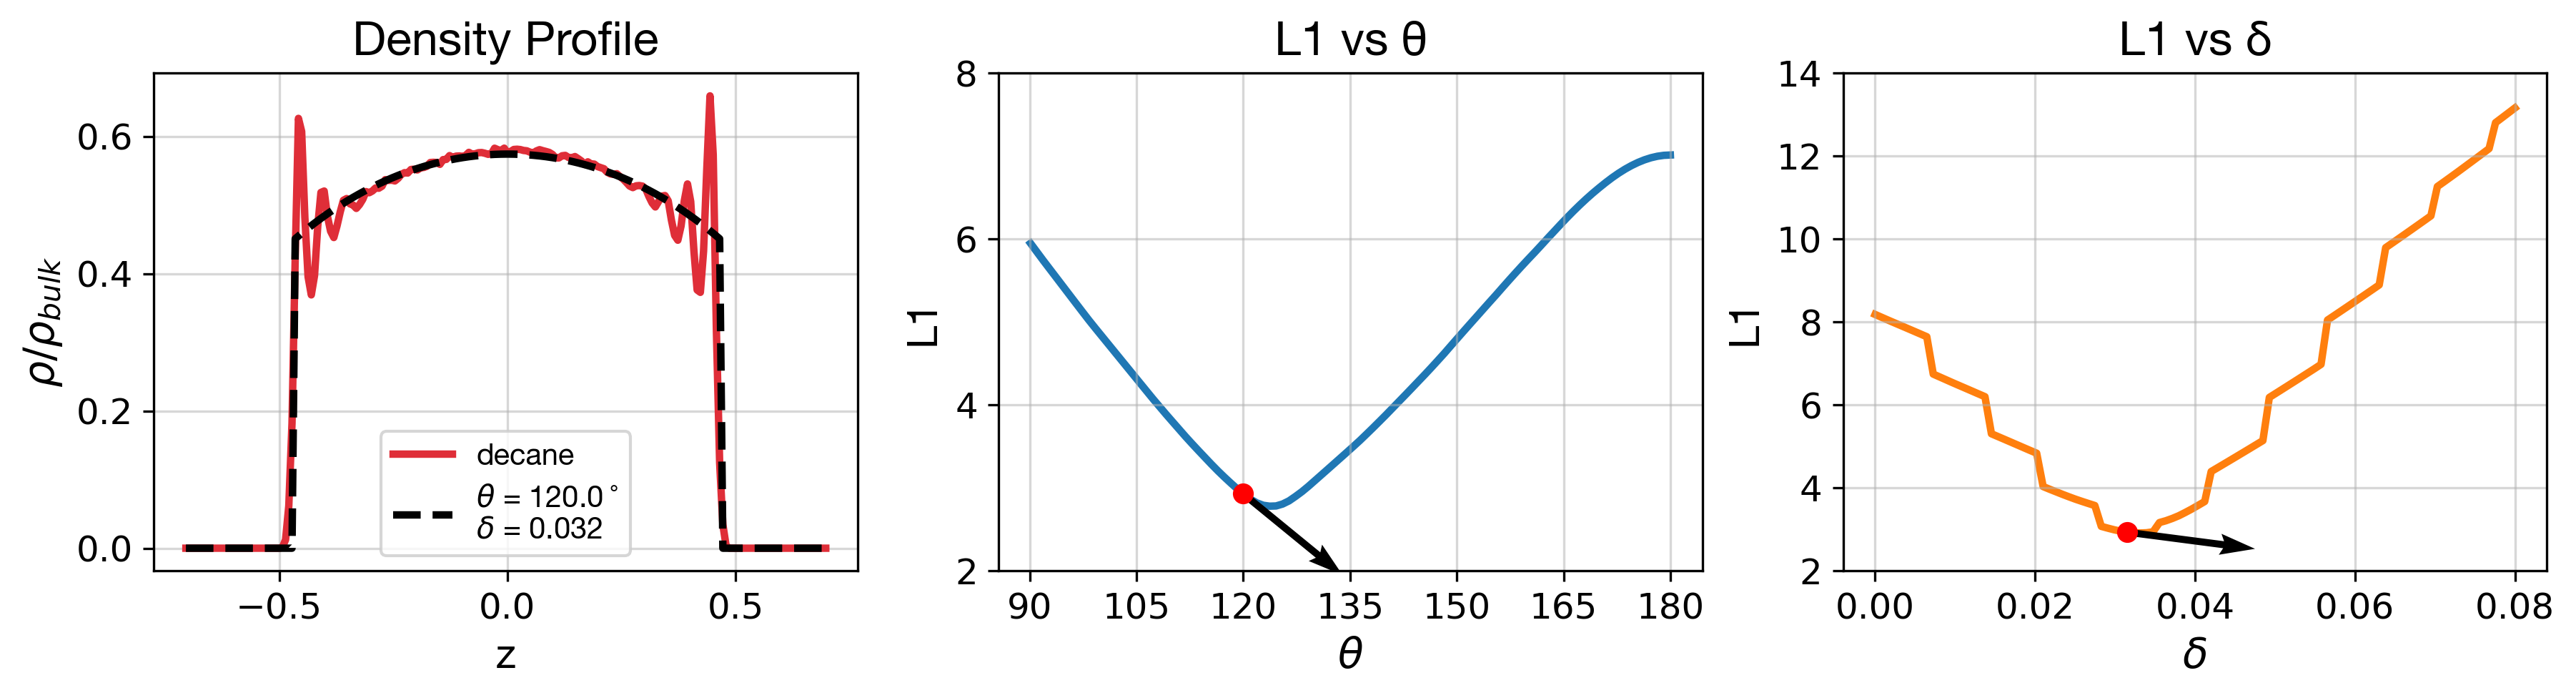

11


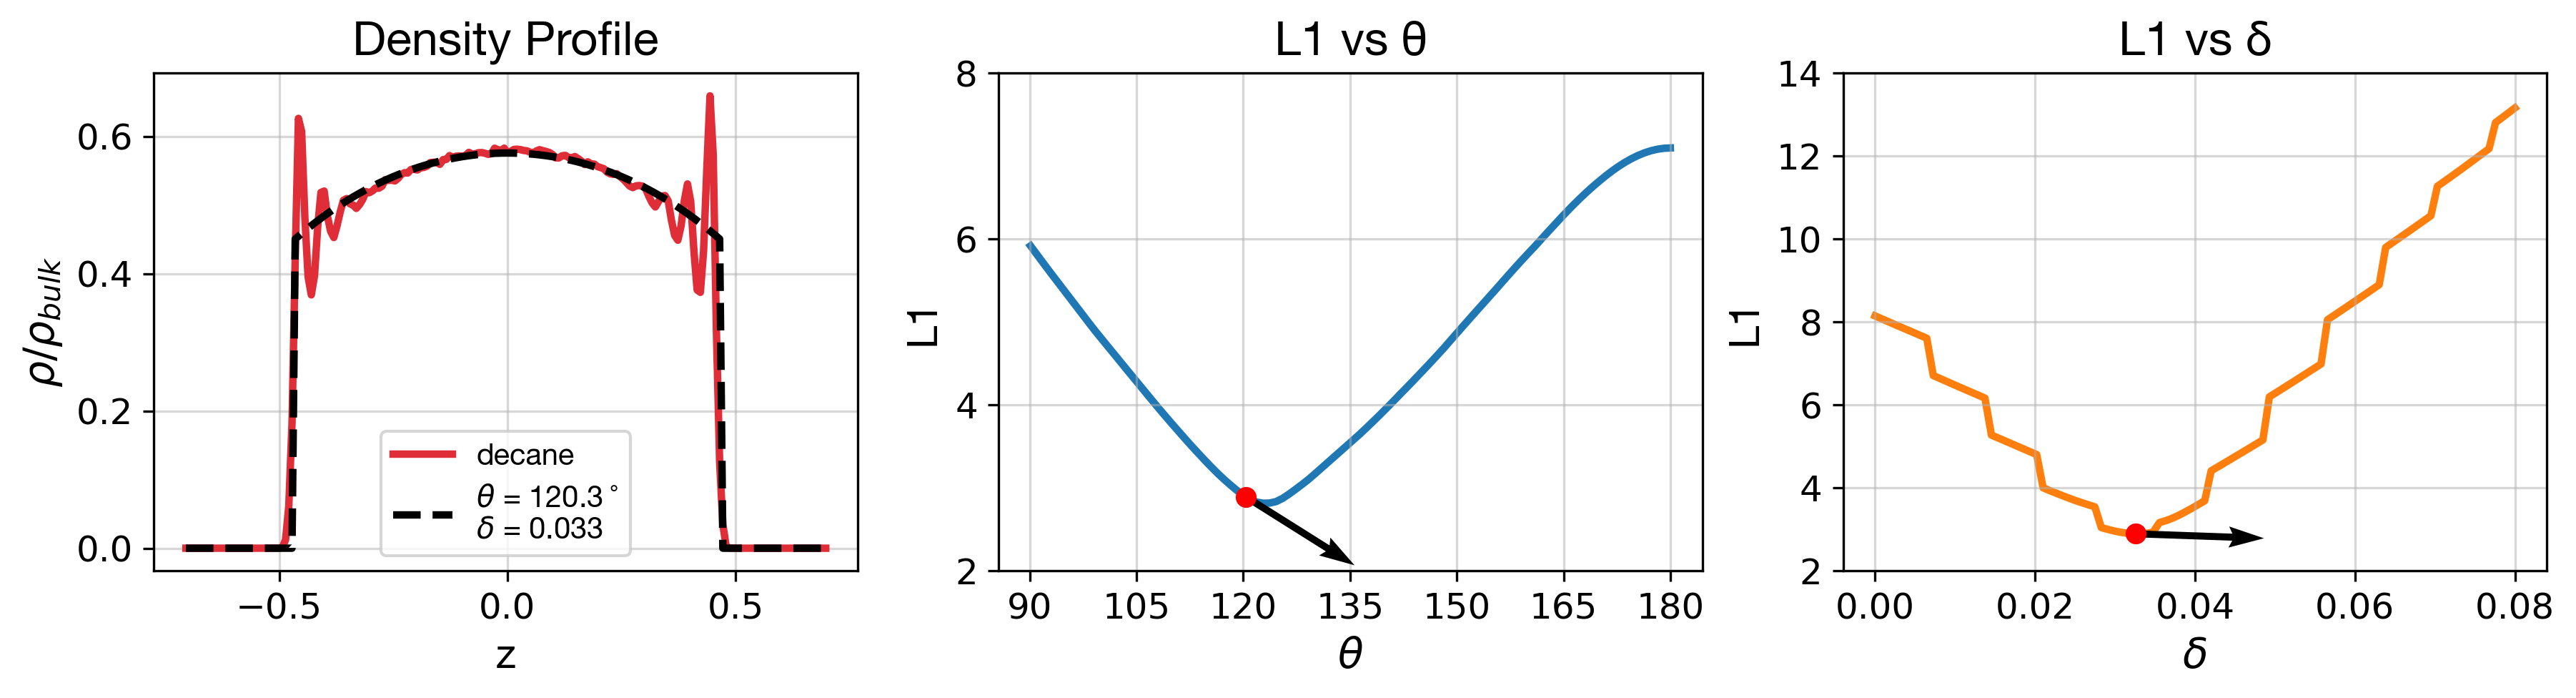

12


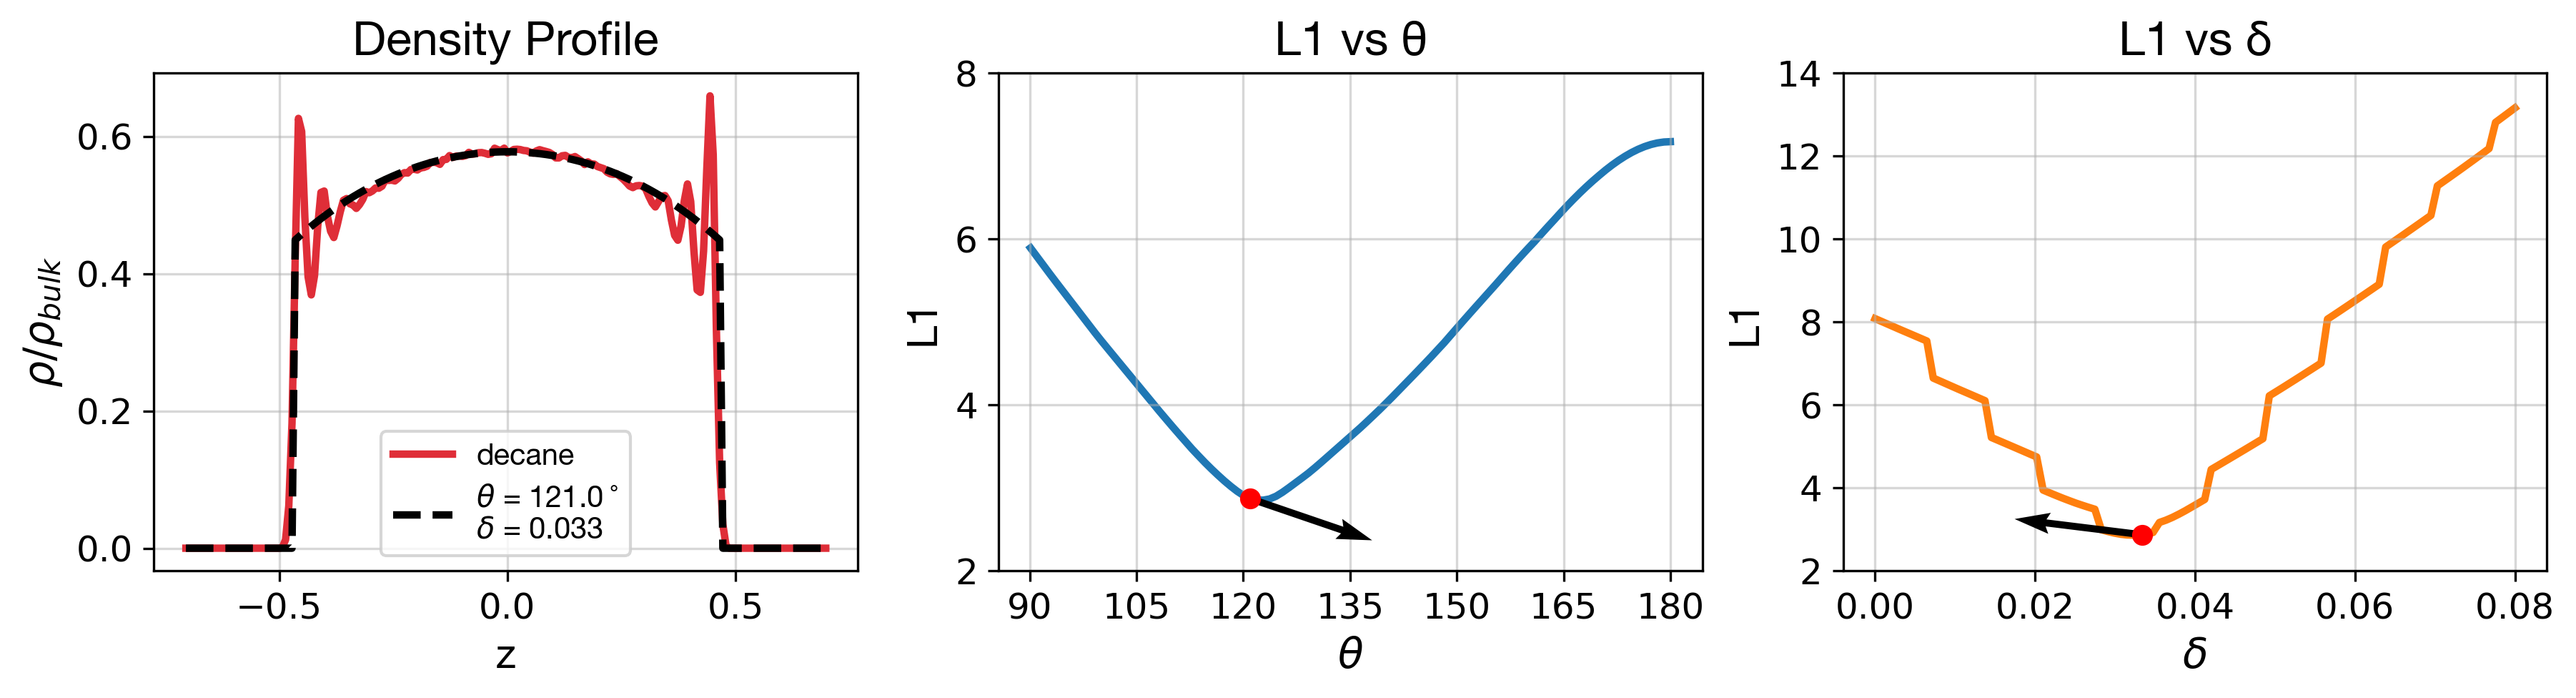

13


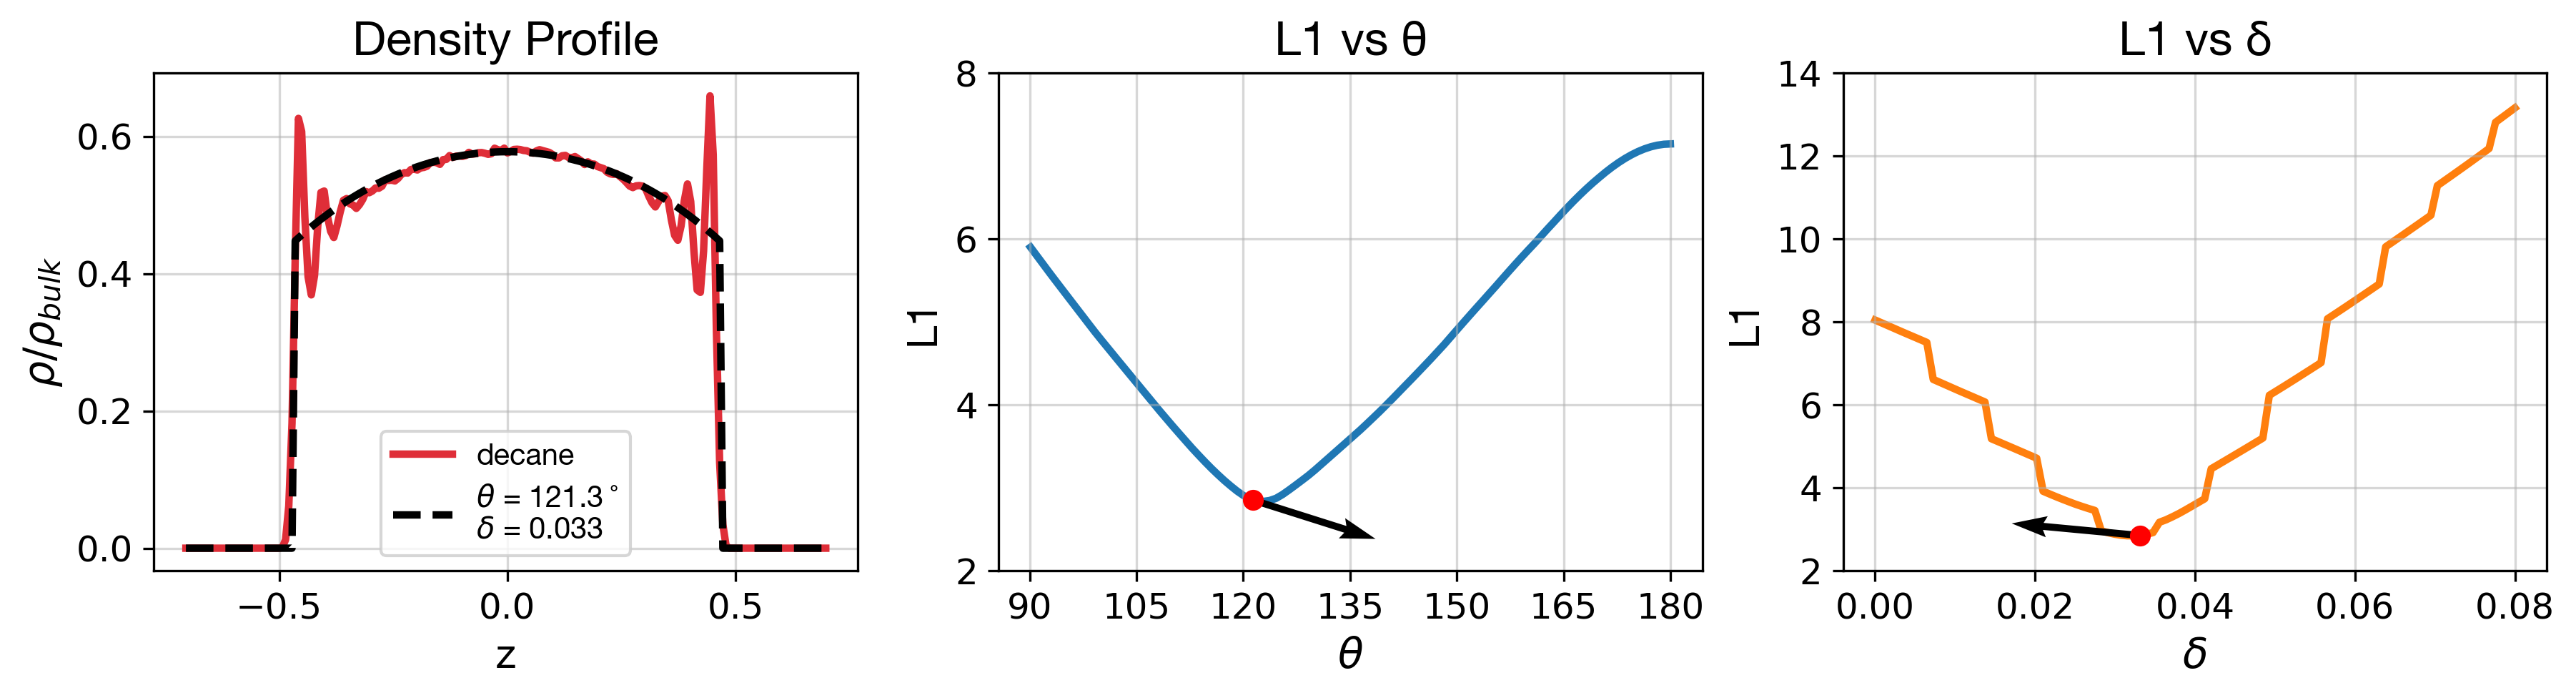

14


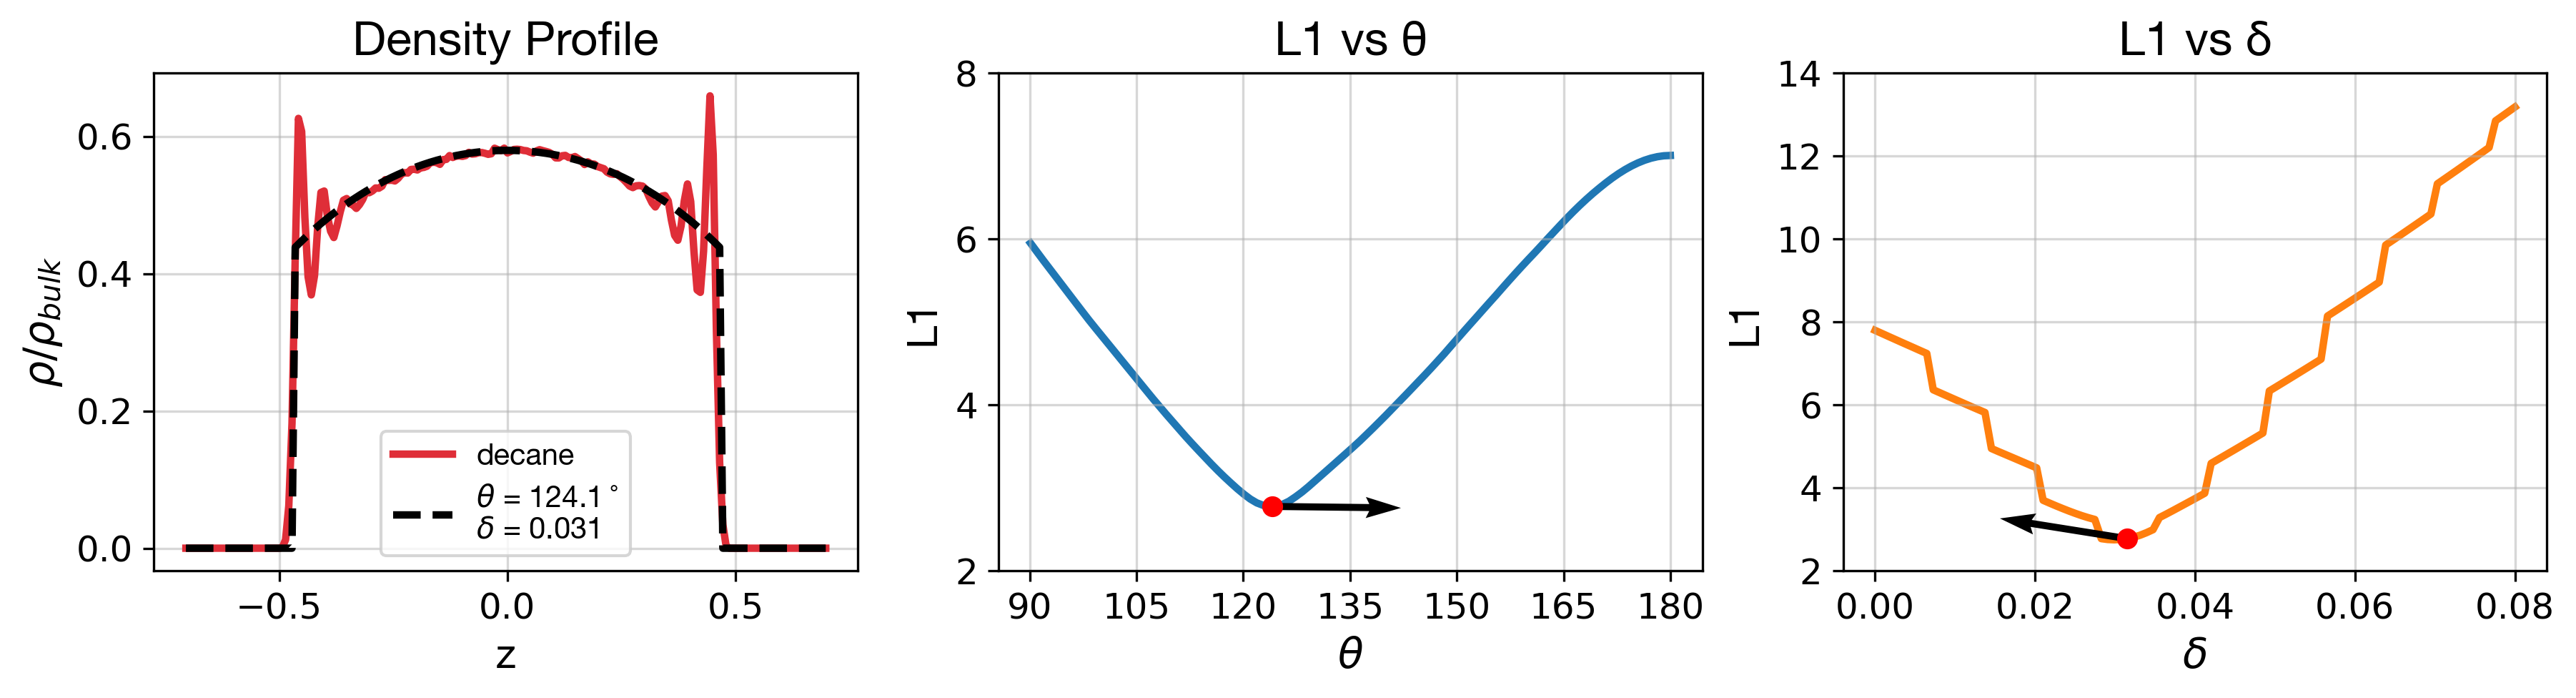

15


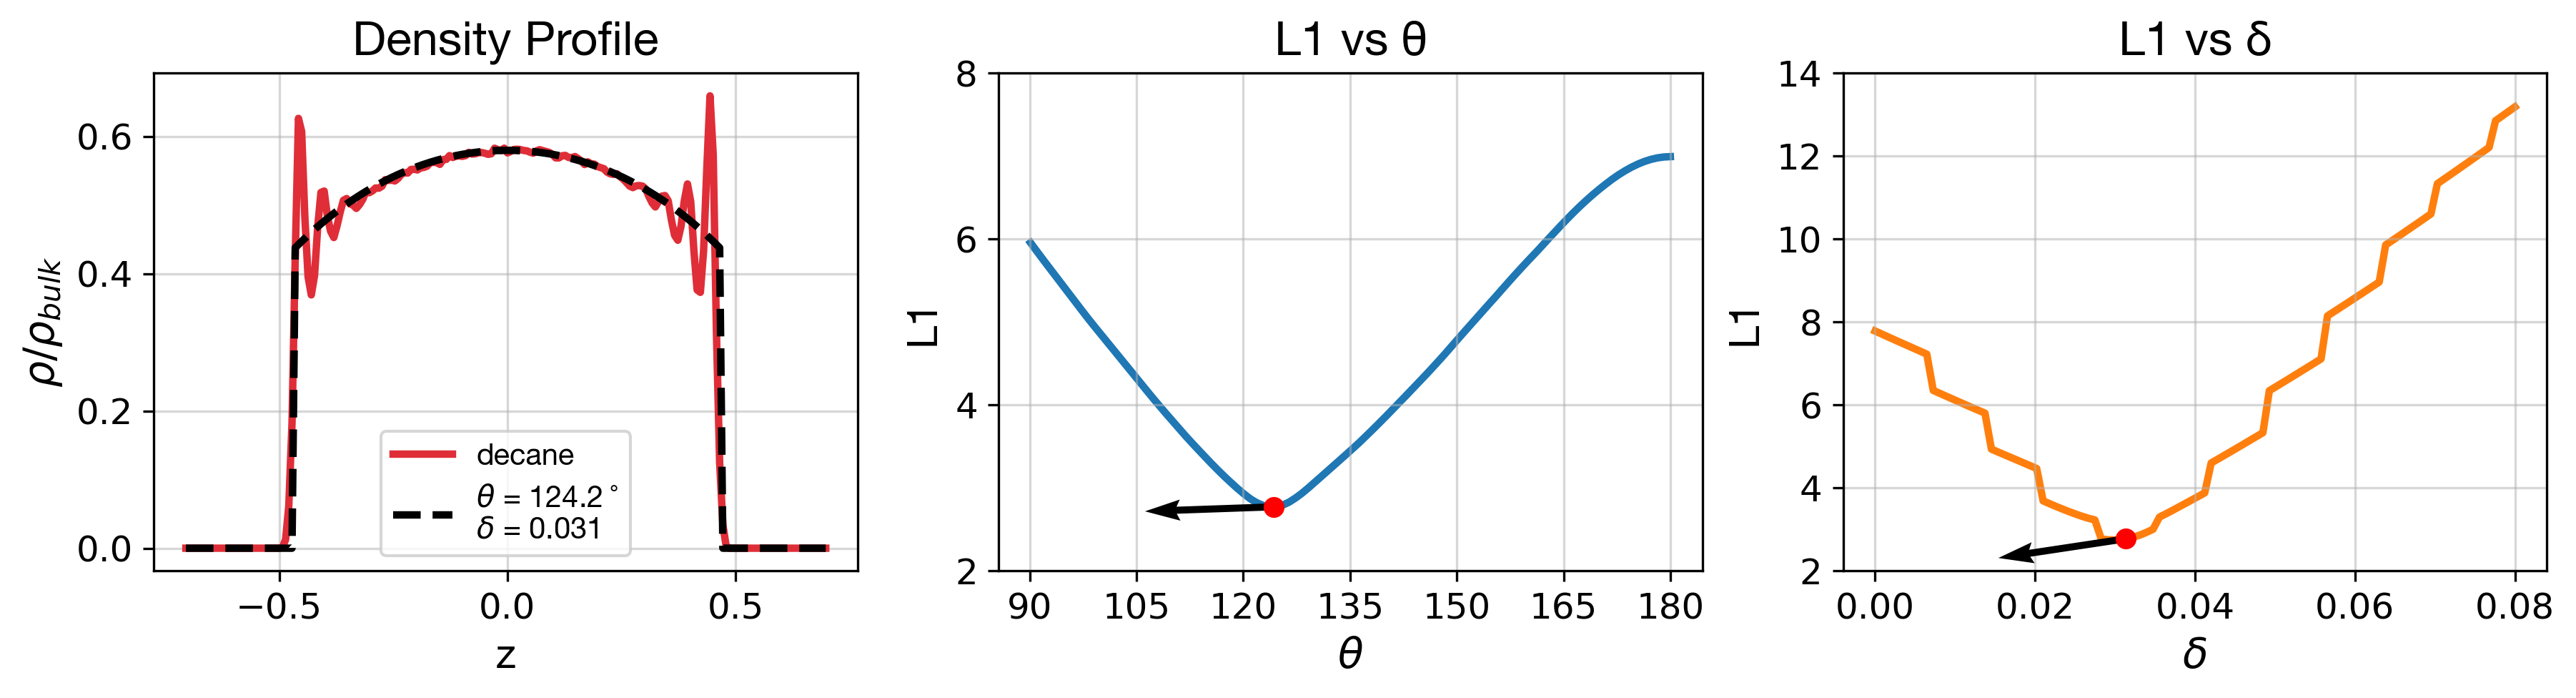

16


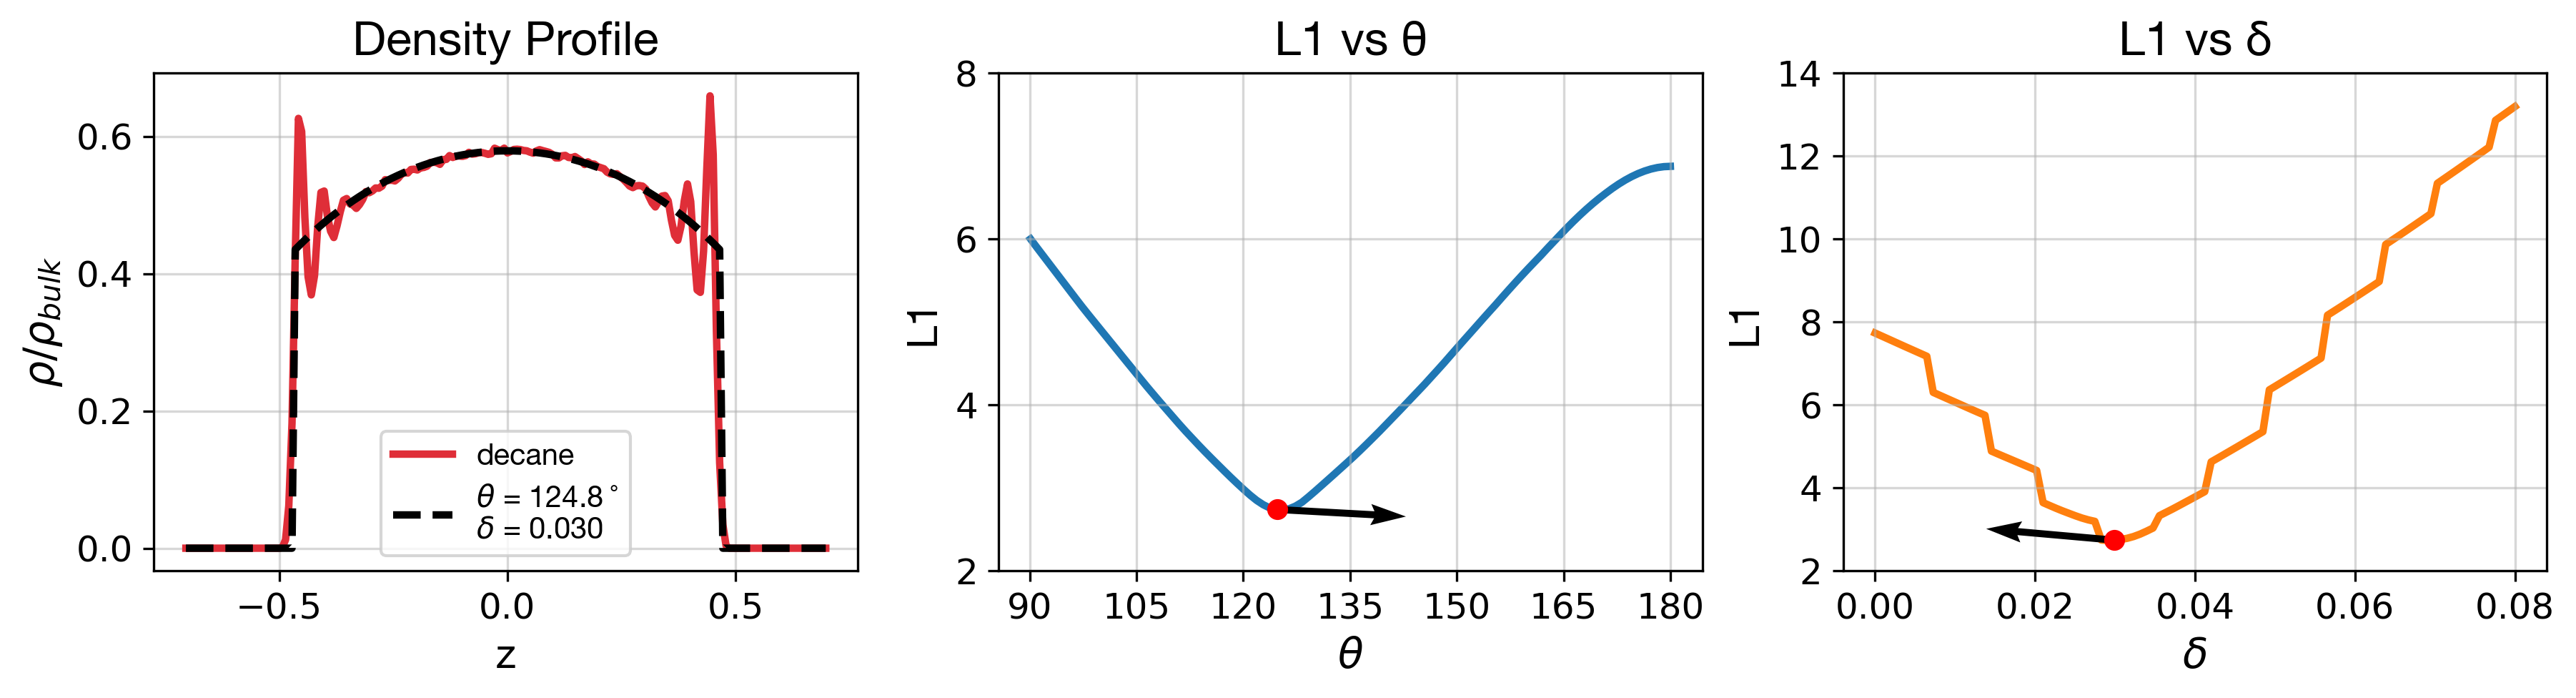

17


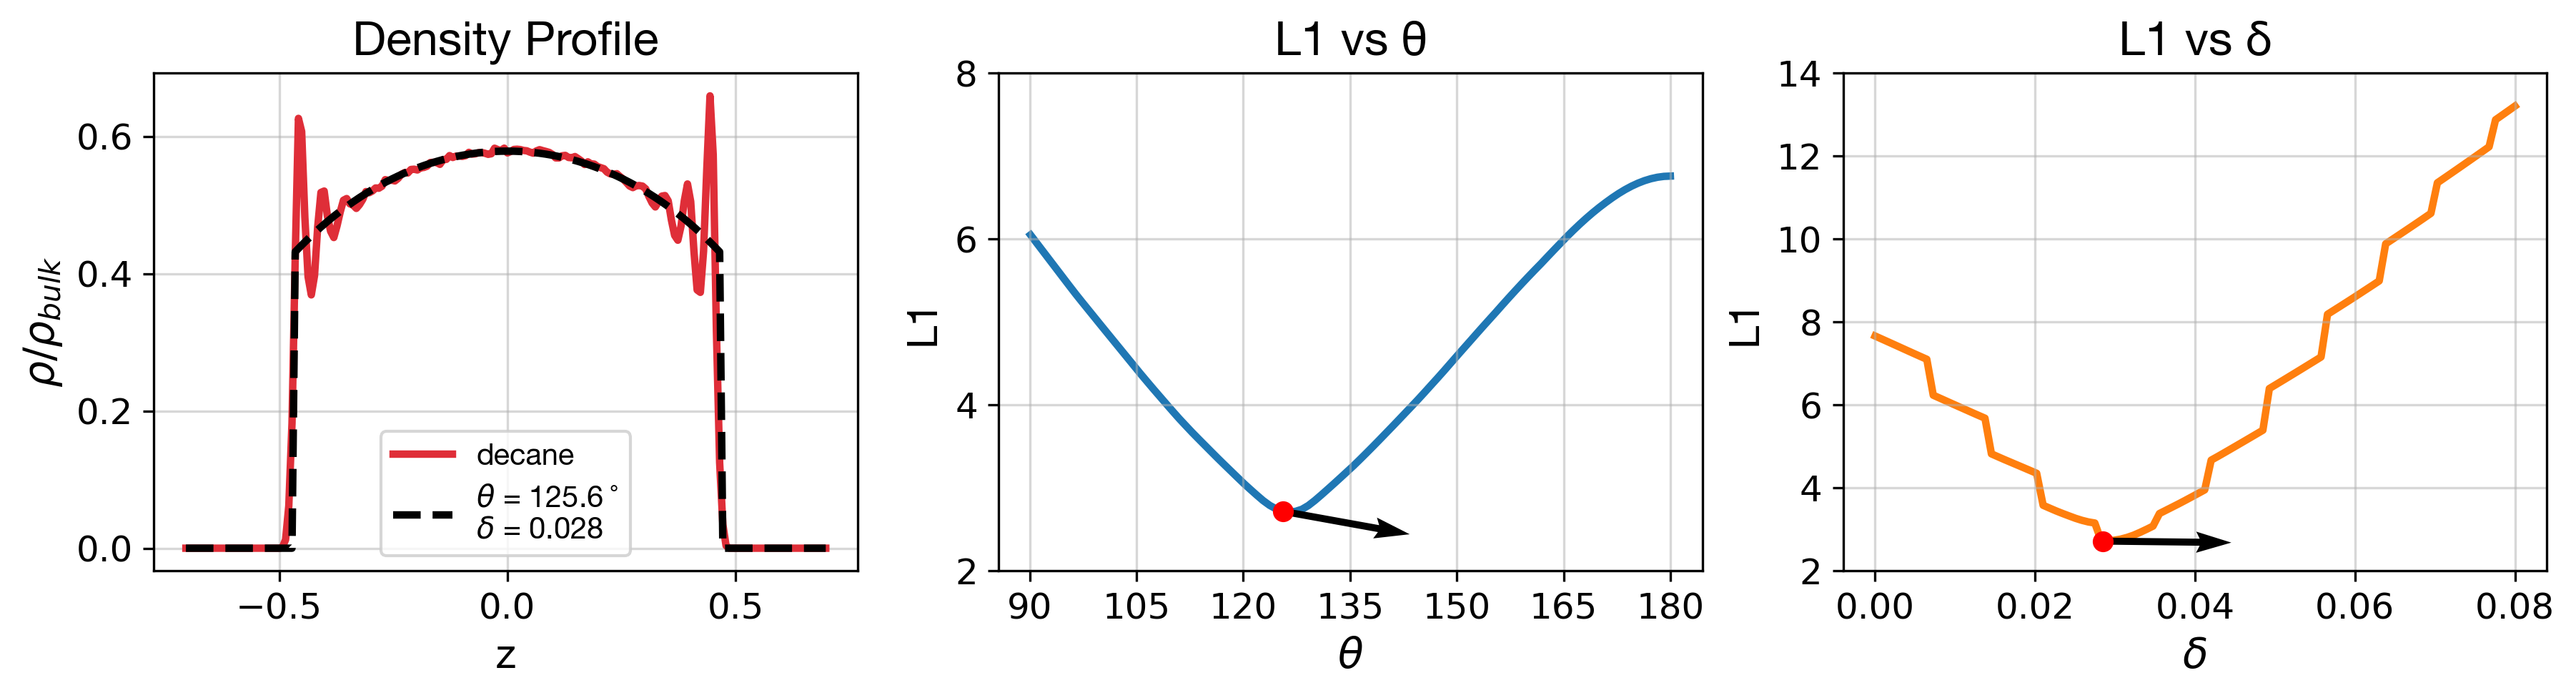

18


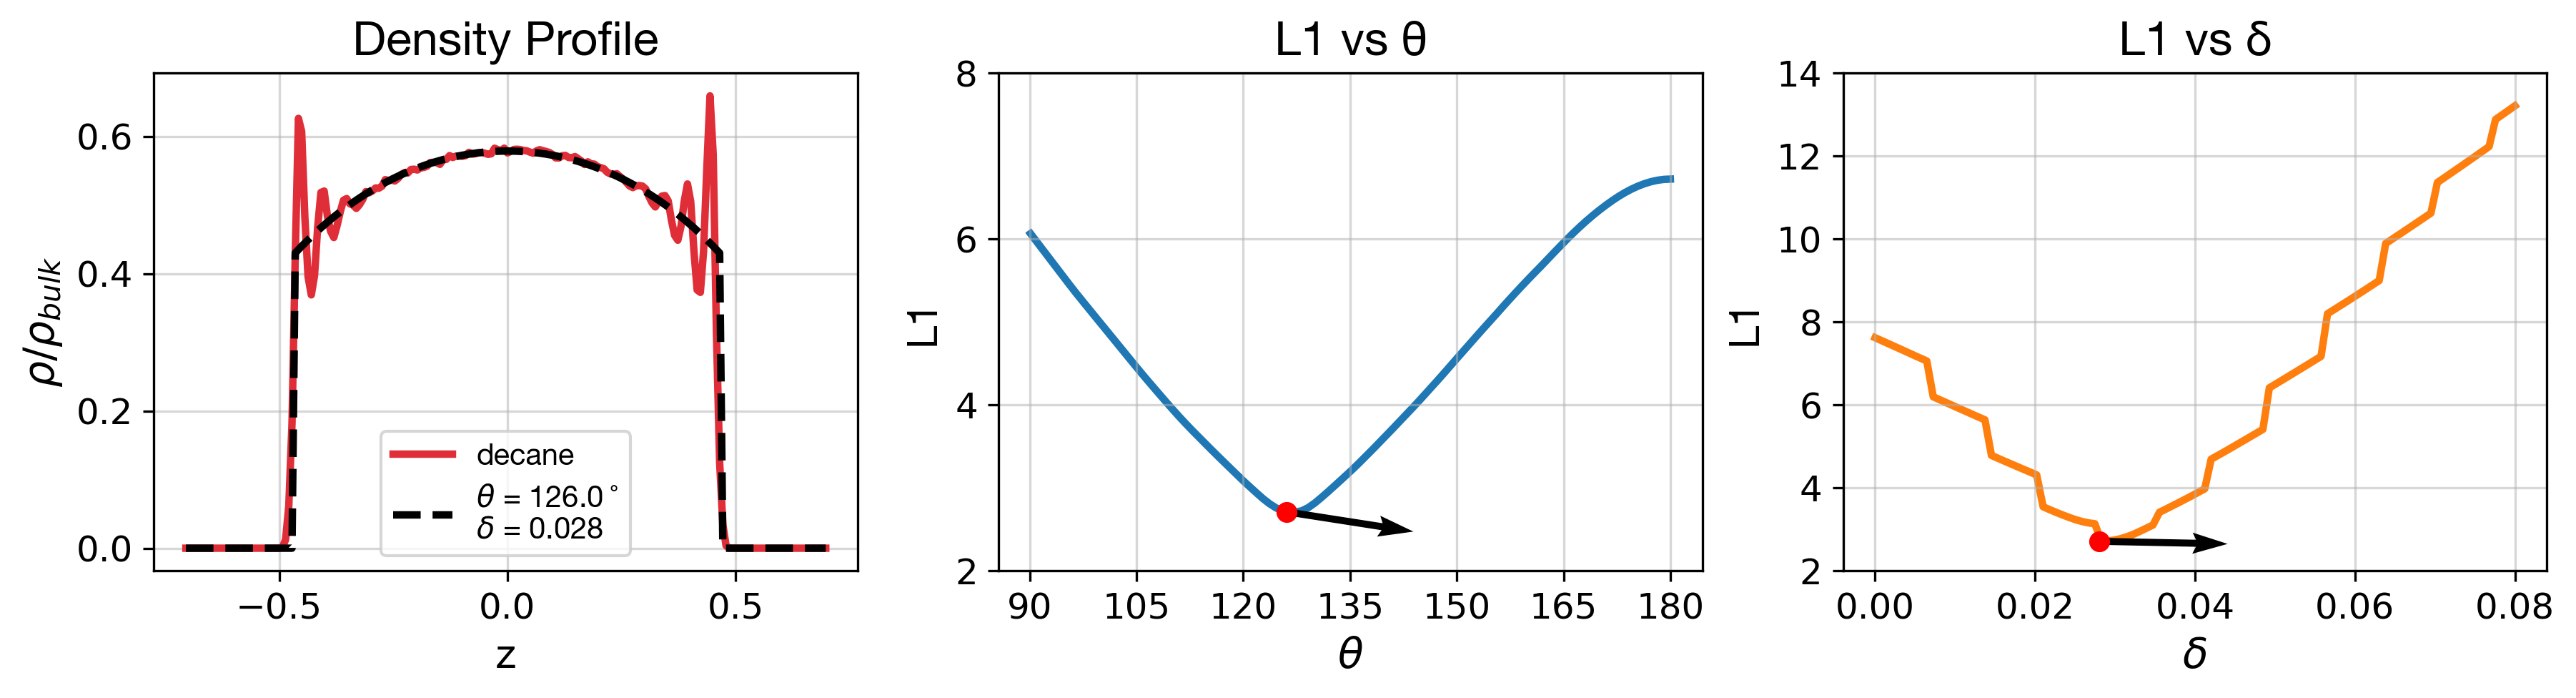

19


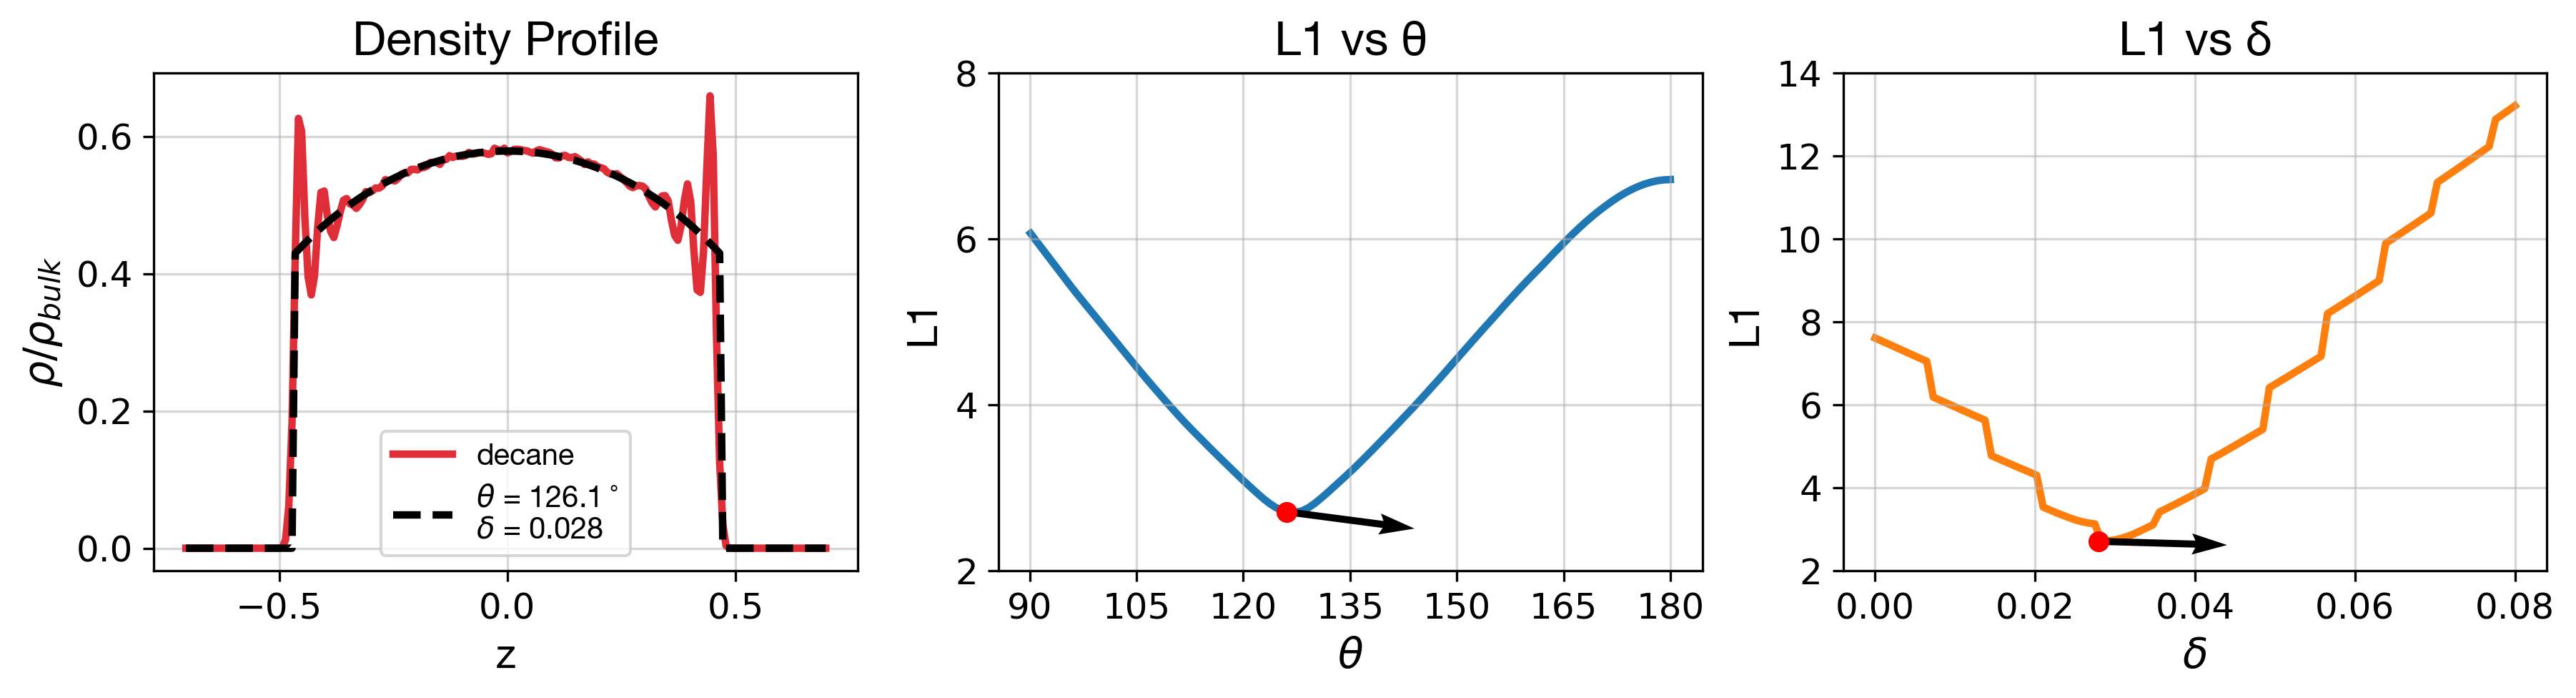

20


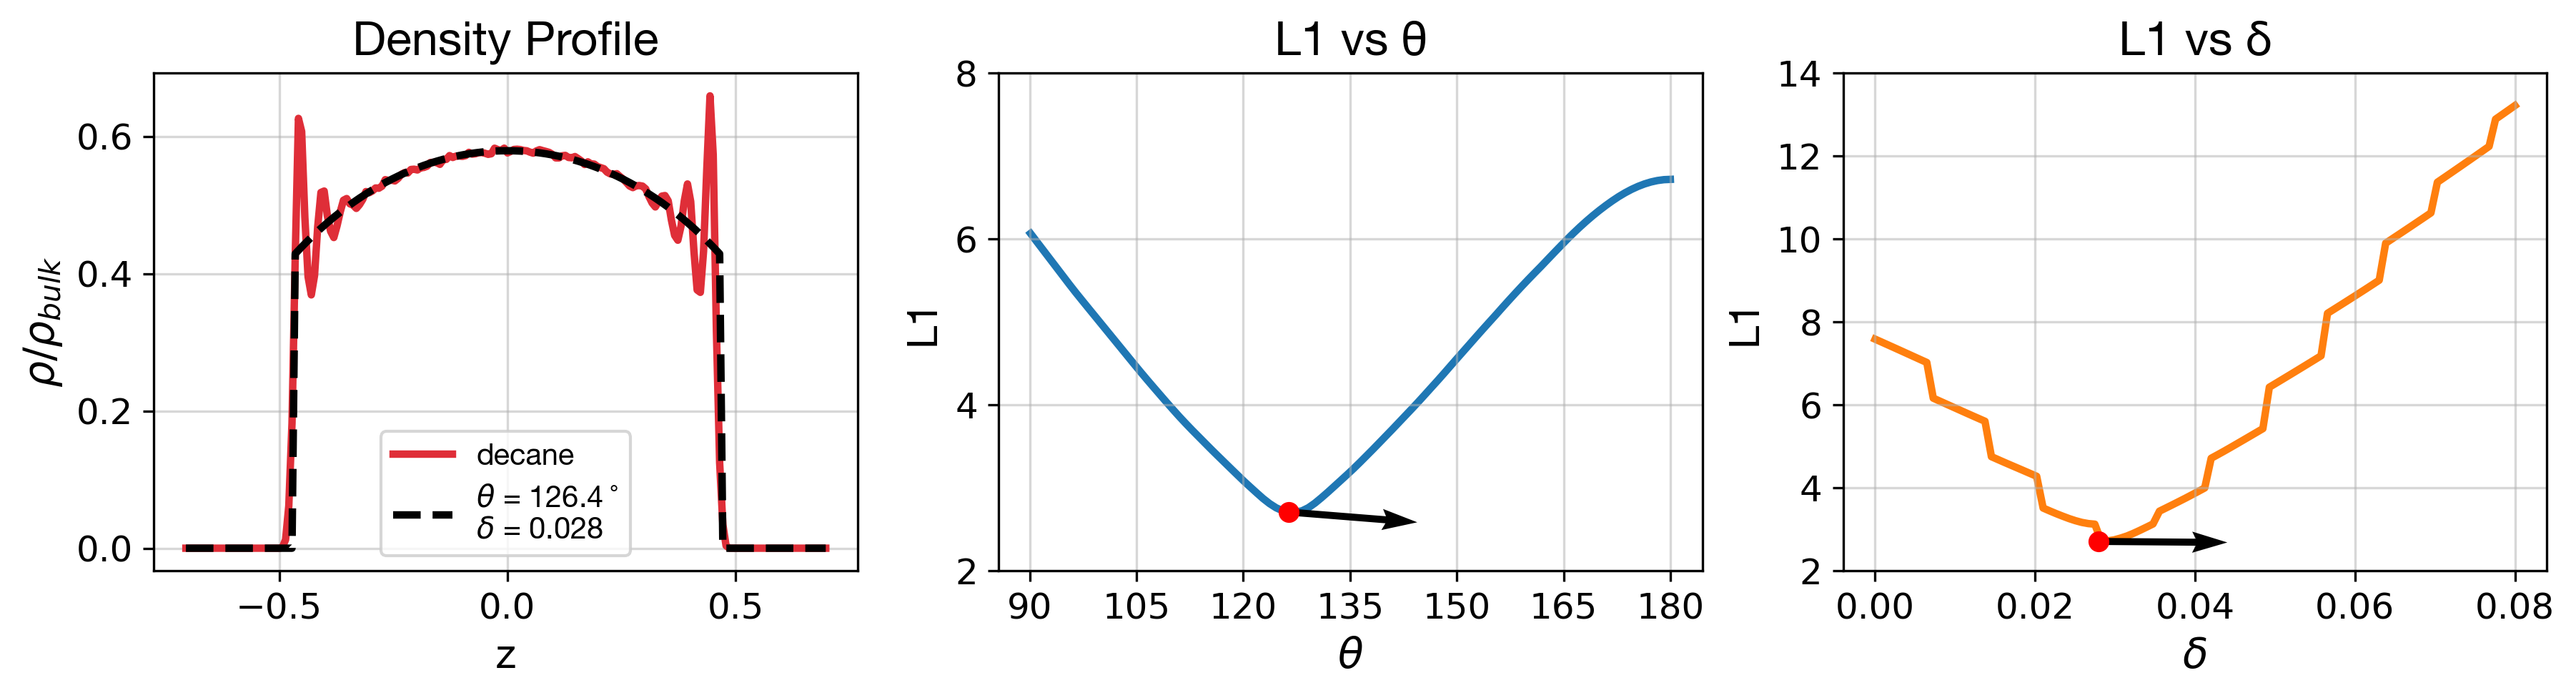

21


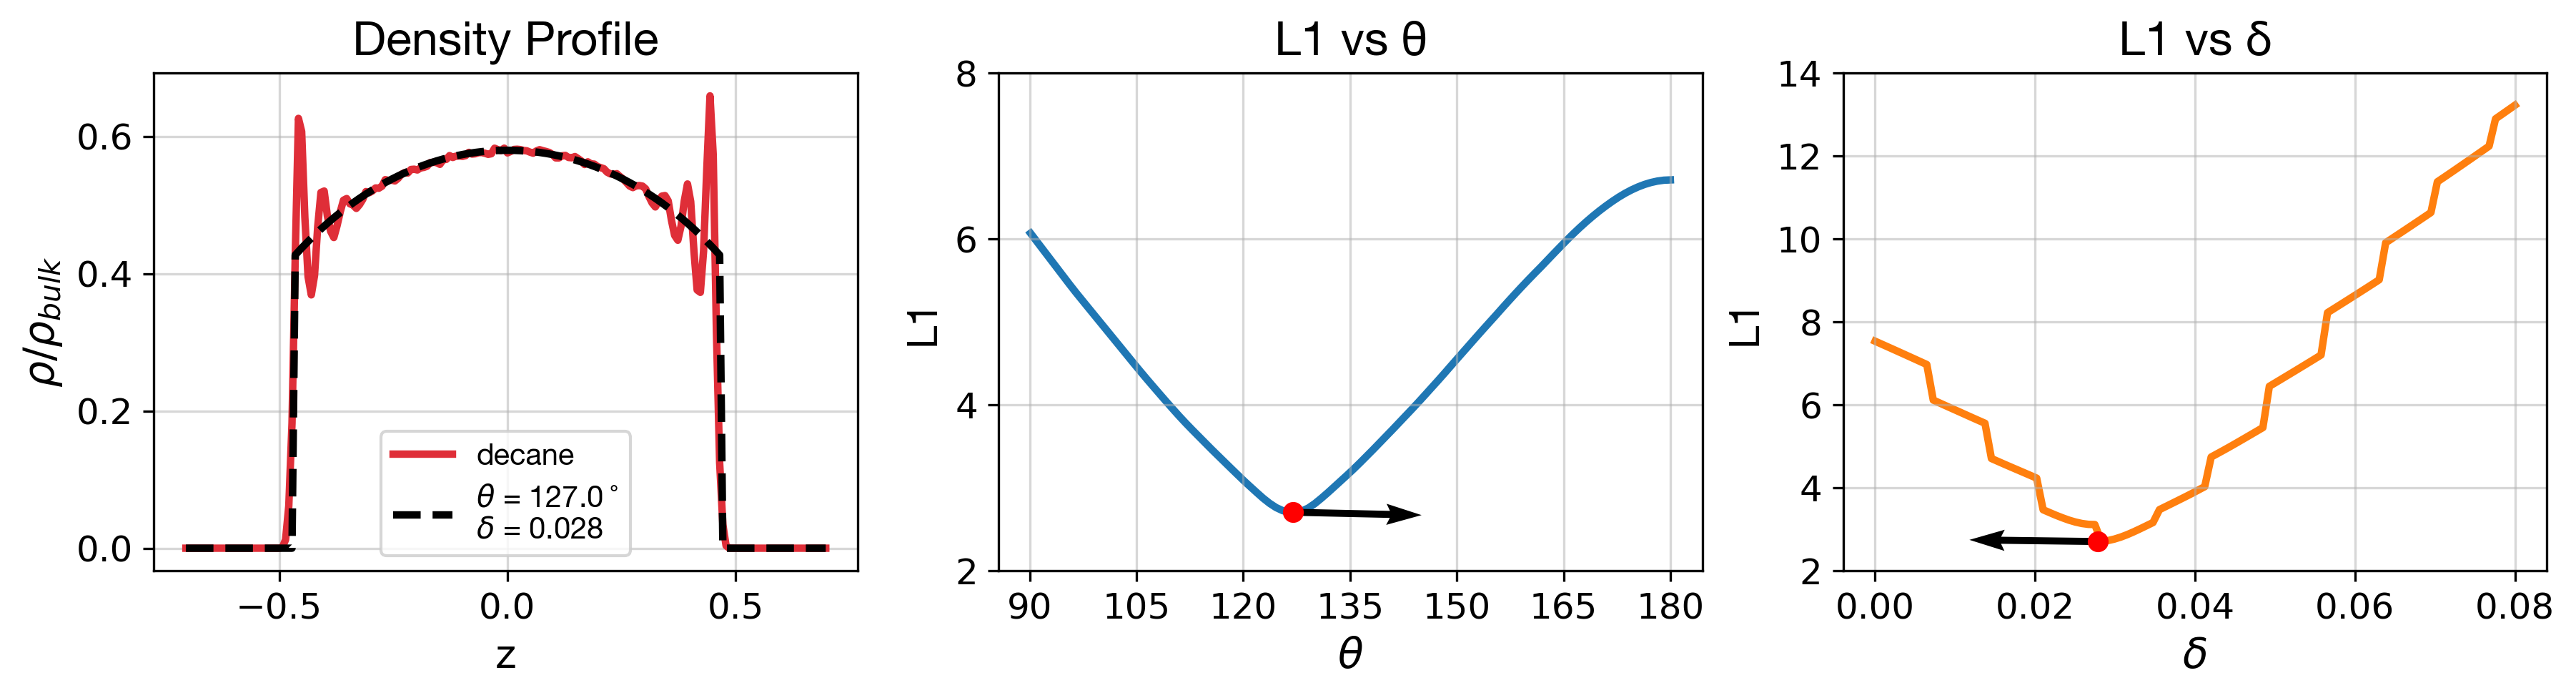

In [28]:
# Directory for saving frames
folder = "../data/frames"
os.makedirs(folder, exist_ok=True)

mpl.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "lines.linewidth": 2.5,
    "lines.markersize": 6
})

rho_func = rho_roll_alpha
grad_rho_func = grad_rho_roll_alpha

# theta_vals = np.linspace(np.pi / 2 + np.deg2rad(1), 2 * np.pi, 100)
theta_vals = np.linspace(90.1, 180, 100)
delta_vals = np.linspace(0, 0.08, 100)

history_interp = np.concatenate(
    (np.linspace(history[0], history[1], 10, endpoint=True),
    history[2:]), axis=0
)

# Iterate over the history
for i, xk in enumerate(history_interp):  # Assume `history` contains the values of `xk` during optimization
    print(i+1)
    theta, delta = xk
    grad = grad_L1(xk, z, dens, l, phi, rho_func, grad_rho_func)
    grad_theta, grad_delta = grad[0], grad[1]
    grad_theta_vector = np.array([-np.sign(grad_theta) * 180 / pi,  -np.sign(grad_theta) * grad_theta]) / np.sqrt((180 / pi)**2 + (grad_theta)**2)
    grad_delta_vector = np.array([-np.sign(grad_delta), -np.sign(grad_theta) * grad_delta]) / np.sqrt(1 + (grad_delta)**2)

    # Compute L1 values for the second and third subplots
    L1_theta = np.array([L1([np.deg2rad(t), delta], z, dens, l, phi, rho_func) for t in theta_vals])
    L1_delta = np.array([L1([theta, d], z, dens, l, phi, rho_func) for d in delta_vals])

    # Create a figure
    scale = 1.2
    fig, axs = plt.subplots(1, 3, figsize=(3*4*scale, 2.51*scale), dpi=300)

    # First subplot: density profile
    axs[0].grid(alpha=0.5)
    axs[0].plot(z, dens, label='decane', color='#DF2E38',
                # linewidth=2.5,
    )
    axs[0].plot(
        z, rho_func(z, l, phi, theta, delta),
        label=r'$\theta$ = {:.1f}$^\circ$'.format(np.rad2deg(theta))
            + '\n' +
            r'$\delta$ = {:.3f}'.format(delta),
        color='#000000', linestyle='dashed',
        # linewidth=2.5
    )

    axs[0].set_xlabel('z',
        fontproperties=helvetica_font,
        fontsize=14
    )
    axs[0].set_ylabel(r'$\rho / \rho_{bulk}$',
        fontproperties=helvetica_font,
        fontsize=14
    )
    axs[0].legend(loc='lower center',
        prop=helvetica_font,
        fontsize=12
    )
    axs[0].set_title('Density Profile',
        fontproperties=helvetica_font,
        fontsize=16
    )

    # Second subplot: L1 vs theta
    axs[1].grid(alpha=0.5)
    axs[1].plot(theta_vals, L1_theta, label='L1 vs θ', color='tab:blue', zorder=1,
        # linewidth=2.5
        )
    axs[1].scatter([np.rad2deg(theta)], [L1([theta, delta], z, dens, l, phi, rho_func)], color='red', zorder=3)
    axs[1].quiver(
        [np.rad2deg(theta)], [L1([theta, delta], z, dens, l, phi, rho_func)],
        *grad_theta_vector,
        angles='xy', scale_units='dots', scale=1/180, color='black', width=0.01, zorder=2
    )
    axs[1].set_ylim(bottom=2)
    axs[1].set_xticks(np.arange(90, 181, 15, dtype=int))
    axs[1].set_yticks(np.arange(2, 2 * (max(L1_theta) // 2 + 1) + 0.1, 2, dtype=int))
    axs[1].set_xlabel(r'$\theta$',
        fontproperties=helvetica_font,
        fontsize=14
    )
    axs[1].set_ylabel('L1',
        fontproperties=helvetica_font,
        fontsize=14
    )
    axs[1].set_title('L1 vs θ',
        fontproperties=helvetica_font,
        fontsize=16
    )
    axs[1].grid(alpha=0.5)

    # Third subplot: L1 vs delta
    axs[2].grid(alpha=0.5)
    axs[2].plot(delta_vals, L1_delta, label='L1 vs δ', color='tab:orange', linewidth=2.5, zorder=1)
    axs[2].scatter([delta], [L1([theta, delta], z, dens, l, phi, rho_func)], color='red', zorder=3)
    axs[2].quiver(
        [delta], [L1([theta, delta], z, dens, l, phi, rho_func)],
        *grad_delta_vector,
        angles='xy', scale_units='dots', scale=1/180, color='black', width=0.01, zorder=2
    )
    axs[2].set_ylim(bottom=2)
    axs[2].set_xticks(np.arange(0, 0.081, 0.02))
    axs[2].set_yticks(np.arange(2, 2 * (max(L1_delta) // 2 + 1) + 0.1, 2, dtype=int))
    axs[2].set_xlabel(r'$\delta$',
        fontproperties=helvetica_font,
        fontsize=14
    )
    axs[2].set_ylabel('L1',
        fontproperties=helvetica_font,
        fontsize=14
    )
    axs[2].set_title('L1 vs δ',
        fontproperties=helvetica_font,
        fontsize=16
    )

    # Adjust layout and save frame
    # plt.tight_layout()
    plt.savefig(os.path.join(folder, f"frame_{i:03d}.png"), dpi=300, bbox_inches='tight')
    plt.show()
    # plt.close(fig)